In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from scipy.stats import randint as sp_randint
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn import preprocessing
from sklearn.decomposition import PCA

import statsmodels.api as sm

## Load data

In [2]:
## Load data

gss = pd.read_csv('../../GSS_2012/ICPSR_35478/DS0001/35478-0001-Data.tsv', sep='\t')
print(gss.shape)
gss.head()

(4820, 1069)


,YEAR,ID,INTID,FEEUSED,FEELEVEL,DATEINTV,LNGTHINV,INTAGE,INTETHN,MODE,...,SAMPCODE,SAMPLE,OVERSAMP,WTSS,WTSSNR,WTSSALL,WTCOMB,WTCOMBNR,VSTRAT,VPSU
0,2012,1,49,1,75,721,69,60,1,1,...,601,10,1,2.621963,2.869532,2.621963,6.402159,7.006659,-1,-1
1,2012,2,150,1,75,624,53,32,1,1,...,601,10,1,3.495950,3.826043,3.495950,6.514477,7.129583,-1,-1
2,2012,3,150,1,75,627,77,32,1,1,...,601,10,1,1.747975,1.913021,1.747975,1.671130,1.828920,-1,-1
3,2012,4,49,1,20,527,78,60,1,1,...,601,10,1,1.235694,1.352370,1.235694,1.181370,1.292917,-1,-1
4,2012,5,235,1,75,620,149,62,1,1,...,601,10,1,0.873988,0.956511,0.873988,0.835565,0.914460,-1,-1


## Select useful features manually

In [3]:
## Most useful features with majority responses

gss_select = pd.DataFrame({
    'age': gss['AGE'], #p60
    'yob': gss['COHORT'],
    'sex': gss['SEX'], #p87
    'race': gss['RACECEN1'], #p291
    'siblings': gss['SIBS'], #p58
    'region': gss['REGION'], #p103
    'place_size_000s': gss['SIZE'], #p105
    'place_size': gss['XNORCSIZ'], #p104
    'beltcode': gss['SRCBELT'], #p105
    'work_status': gss['WRKSTAT'],
    'hours': gss['HRS1'], #p.21
    'self_employed': gss['WRKSLF'],
    'occupation': gss['OCC10'],
    'income': gss['RINCOME'], #p100
    'income_granular': gss['RINCOM06'], #p102
    'highest_school': gss['EDUC'], #p64
    'highest_degree': gss['DEGREE'], #p68
    'major': gss['MAJOR1'], #p70
    'residence_16' : gss['RES16'], #p88
    'region_16': gss['REG16'], #p89
    'family_16': gss['FAMILY16'], #90
    'live_who_16': gss['FAMDIF16'], #91
    'fam_income_16': gss['INCOM16'], #92
    'relig_raised': gss['RELIG16'], #p.186
    'geo_mobility': gss['MOBILE16'], #p90
    'mother_employed': gss['MAWRKGRW'], #92
    'father_school': gss['PAEDUC'], #p65
    'mother_school': gss['MAEDUC'], #p66
    'father_degree': gss['PADEG'], #p68
    'mother_degree': gss['MADEG'], #p69
    'father_occupation': gss['PAOCC10'], #p.45
    'mother_occupation': gss['MAOCC10'], #p51
    'father_self_employed': gss['PAWRKSLF'], #p.45
    'mother_self_employed': gss['MAWRKSLF'], #p51
    'class': gss['CLASS'], #p.236
    'happiness': gss['HAPPY'], #p210
    'pol_party': gss['PARTYID'], #p140
    'pol_views': gss['POLVIEWS'], #p142
    'vote_2008': gss['VOTE08'], #p140
    'pres_2008': gss['PRES08'], #p141
    'if_pres_2008': gss['IF08WHO'], #P141
    'religion': gss['RELIG'], #p.175
    'religion_strength': gss['RELITEN'], #p183
    'fundamentalist': gss['FUND'], #p182
    'rel_attend': gss['ATTEND'], #p182
    'rel_person': gss['RELPERSN'],
    'spi_person': gss['SPRTPRSN'],
    'post_life': gss['POSTLIFE'], #p184
    'pray': gss['PRAY'], #p184
    'bible': gss['BIBLE'], #p206
    'god': gss["GOD"],
    'born_again': gss['REBORN'],
    'save_soul': gss['SAVESOUL'],
    'rel_activities': gss['RELACTIV'],
    'op_road': gss['NATROAD'], #p149
    'op_socsec': gss['NATSOC'], #p150
    'op_masstrans': gss['NATMASS'], #p151
    'op_parks': gss['NATPARK'], #p152
    'op_childcare': gss['NATCHLD'], #p153
    'op_scires': gss['NATSCI'], #p154
    'op_cappun': gss['CAPPUN'], #p173
    'op_gunlaws': gss['GUNLAW'], #173
    'op_criminals': gss['COURTS'] #p174
    
})

In [4]:
## Features that might have label leakage

gss_may_hint = pd.DataFrame({
    'dwelling_type': gss['DWELLING'], #p295
    'children': gss['CHILDS'], #p59
    'age_1st_child': gss['AGEKDBRN'], #P62
    'sex_orient': gss['SEXORNT'] #p277
})

In [5]:
## Outcome variable

gss_marital_status = pd.DataFrame({
    'marital_status' : gss['MARITAL'],
    'ever_divorced' : gss['DIVORCE'],
    'ever_widowed' : gss['WIDOWED']
})

In [6]:
## marital_status: 1-Married, 2-Widowed, 3-Divorced, 4-Separated, 5-Never married, 9-No answer
## ever_divorced: 1-Yes, 2-No, 0-Inapplicable, 8-Don't know, 9-No answer
## ever_widowed: 1-Yes, 2-No, 0-Inapplicable, 8-Don't know, 9-No answer
gss_marital_status.head()

,marital_status,ever_divorced,ever_widowed
0,5,0,0
1,5,0,0
2,1,2,2
3,1,1,2
4,4,0,2


In [7]:
## Create binary outcome variable

gss_divsep = pd.DataFrame({
    'ever_divsep': np.where(gss_marital_status['marital_status'].isin([3, 4]), 1, 0) + np.where(gss_marital_status['ever_divorced'] == 1, 1, 0)
})

In [8]:
gss_divsep.head()

,ever_divsep
0,0
1,0
2,0
3,1
4,1


In [9]:
## Why so many non responses for income?

gss_income = gss.loc[gss['RINCOM06'] == 0, ]

In [10]:
gss_income.VERSION.value_counts()

2    619
3    577
1    566
Name: VERSION, dtype: int64

In [11]:
gss_income.SAMPTYPE.value_counts()

2012    723
2010    567
2008    472
Name: SAMPTYPE, dtype: int64

## Create features and record NAs

In [12]:
## Create features and record NAs

In [13]:
dummies_needed = []
gss_features = pd.DataFrame()
gss_nas = pd.DataFrame({
    'variable': gss_select.columns,
    'inapplicable': np.nan,
    'dont_know': np.nan,
    'no_answer': np.nan
})

gss_nas.set_index(['variable'], drop=True, inplace=True)
gss_nas.head()

,inapplicable,dont_know,no_answer
variable,,,
age,NaN,NaN,NaN
yob,NaN,NaN,NaN
sex,NaN,NaN,NaN
race,NaN,NaN,NaN
siblings,NaN,NaN,NaN


In [14]:
## Filling in gss_nas

def fill_gn(row, col, value):
    gss_nas.loc[row, col] = (gss_select[row] == value).sum()
    

#### Age

In [15]:
## Fill in NAs
gss_nas.loc['age', 'dont_know'] = (gss_select['age'] == 98).sum()
fill_gn('age', 'no_answer', 99)

## Create feature with NAs
gss_features['age'] = np.where(gss_select['age'] == 99, np.nan, gss_select['age'])

## Display results
print(gss_nas.head())
print(gss_features.head())

          inapplicable  dont_know  no_answer
variable                                    
age                NaN        0.0       51.0
yob                NaN        NaN        NaN
sex                NaN        NaN        NaN
race               NaN        NaN        NaN
siblings           NaN        NaN        NaN
    age
0  22.0
1  21.0
2  42.0
3  49.0
4  70.0


#### YOB

In [16]:
## Ignoring this as duplicates age

#### Sex (p.87)

In [17]:
## 1-Male, 2-Female in survey
## Code to 0-Female, 1-Male

gss_features['sex'] = np.where(gss_select['sex'] == 2, 0, 1)

#### Race (p.291)

In [18]:
fill_gn('race', 'dont_know', 98)
fill_gn('race', 'no_answer', 99)

## If less than 1% code as other
race_dict = {
    1: 'white',
    2: 'black',
    3: 'american_indian',
    4: 'other', #'asian indian', 
    5: 'other', #'chinese', 
    6: 'other', #'filipino', 
    7: 'other', #'japanese', 
    8: 'other', #'korean', 
    9: 'other', # vietnamese
    10: 'other', #other asian 
    11: 'other', #native hawaiian 
    12: 'other', #Guamanian or Chamorro 
    13: 'other', #Samoan 
    14: 'other', #Other pacific islander 
    15: 'other', #another race 
    16: 'hispanic', 
    98: 'other',
    99: 'other'
}

gss_features['race'] = gss_select['race'].replace(race_dict)
dummies_needed.append('race')

## Can code 98 and 99 as 'other' because if obvious interviewer codes it.

#### Siblings p.58

In [19]:
fill_gn('siblings', 'dont_know', 98)
fill_gn('siblings', 'no_answer', 99)
gss_features['siblings'] = np.where(gss_select['siblings'].isin([98, 99]), np.nan, gss_select['siblings'])

#### Region p.103

In [20]:
region_dict = {
    1: 'New_England',
    2: 'Middle_Atlantic',
    3: 'East_North_Central',
    4: 'West_North_Central',
    5: 'South_Atlantic',
    6: 'East_South_Central',
    7: 'West_South_Central',
    8: 'Mountain',
    9: 'Pacific',
    0: np.nan
}

fill_gn('region', 'no_answer', 0)

gss_features['region'] = gss_select['region'].replace(region_dict)

dummies_needed.append('region')

#### Place size 000s p.105

In [21]:
gss_select.loc[gss_select['place_size_000s'] <0,]

,age,yob,sex,race,siblings,region,place_size_000s,place_size,beltcode,work_status,...,rel_activities,op_road,op_socsec,op_masstrans,op_parks,op_childcare,op_scires,op_cappun,op_gunlaws,op_criminals


In [22]:
## No missing values (-1) so no cleaning needed

gss_features['place_size_000s'] = gss_select['place_size_000s']

#### Place size p.104

In [23]:
## Not used - replicates previous

#### Beltcode p.105

In [24]:
## Use this to code urban / suburban / countryside

urban_dict = {
    1: 'urban',
    2: 'urban',
    3: 'suburban',
    4: 'suburban',
    5: 'urban',
    6: 'rural', 
}

gss_features['beltcode'] = gss_select['beltcode'].replace(urban_dict)

dummies_needed.append('beltcode')

#### Work status p.20

In [25]:
## Potential leakage here from keeping house and part time. Ignore.

#### Hours worked last week p.21

In [26]:
## -1 is inapplicable, 98 is don't know, 99 is no answer

fill_gn('hours', 'inapplicable', -1)
fill_gn('hours', 'dont_know', 98)
fill_gn('hours', 'no_answer', 99)

gss_features['hours_worked'] = gss_select['hours']

gss_features.loc[gss_features['hours_worked'] == -1, 'hours_worked'] = 0

gss_features.loc[gss_features['hours_worked'].isin([98,99]), 'hours_worked'] = np.nan


#### Self employed p.25

In [27]:
## Only 131 inapplicables doesn't make sense with work status results.
## Leave out.

#### Occupation p.26

In [28]:
## The numbers do not tally with the totals for each occupation in 
## appendix F. Maybe Appendix F doesn't include all panels?

len(gss['OCC10'].unique())

421

In [29]:
occs = gss_select['occupation'].value_counts().to_frame('counts').sort_values('counts', ascending=False)
occs['percentage'] = occs['counts'] / occs['counts'].sum()
occs.loc[occs['percentage'] > 0.015,]

,counts,percentage
5700,145,0.030083
0,131,0.027178
4760,110,0.022822
4220,110,0.022822
3600,108,0.022407
2310,101,0.020954
9130,96,0.019917
3255,96,0.019917
430,94,0.019502
5240,76,0.015768


In [30]:
## Too small, would create noise - code by general occupation area.

occ_dict = {
    0: 'none',
    430: 'manager',
    950: 'business',
    1240: 'computers_maths',
    1560: 'engineering',
    1965: 'science',
    2060: 'social_services',
    2160: 'legal',
    2550: 'education',
    2960: 'arts',
    3540: 'healthcare_technical',
    3600: 'healthcare_support',
    3955: 'protective_services',
    4160: 'food_prep_serving',
    4250: 'cleaning_maintenance',
    4650: 'personal_care',
    4965: 'sales',
    5940: 'administrative_support',
    6130: 'farming_fishing_forestry',
    6940: 'construction',
    7630: 'installation',
    8965: 'production',
    9750: 'transportation',
    9830: 'military',
    9999: np.nan
    
}

gss_occs = pd.DataFrame()
gss_occs['occs'] = gss_select['occupation']
gss_occs['occs_summary'] = gss_occs['occs']

for occ in occ_dict:
    for row in np.arange(0, len(gss_occs)):
        if(isinstance(gss_occs.loc[row, 'occs_summary'], str)): 
            continue
        if(gss_occs.loc[row, 'occs_summary'] <= occ): 
                gss_occs.loc[row, 'occs_summary'] = occ_dict[occ]
    
gss_features['occupation'] = gss_occs['occs_summary']
dummies_needed.append('occupation')

In [31]:
gss_occs['occs_summary'].value_counts()

administrative_support      609
manager                     458
sales                       419
production                  353
education                   339
food_prep_serving           246
transportation              242
cleaning_maintenance        234
healthcare_technical        223
construction                206
business                    203
personal_care               145
protective_services         134
none                        131
installation                123
healthcare_support          108
computers_maths             103
military                     97
arts                         88
engineering                  87
social_services              81
legal                        42
science                      41
farming_fishing_forestry     41
Name: occs_summary, dtype: int64

#### Income p.102

In [32]:
## Use mid point of ranges

income_dict = {
    1: 500,
    2: 1500,
    3: 3500,
    4: 4500,
    5: 5500,
    6: 6500,
    7: 7500,
    8: 9000,
    9: 11250,
    10: 13750,
    11: 16250,
    12: 18750,
    13: 21250,
    14: 23750,
    15: 27500,
    16: 32500,
    17: 37500,
    18: 45000,
    19: 55000,
    20: 67500,
    21: 82500,
    22: 100000,
    23: 120000,
    24: 140000,
    25: 160000 #guess because uncapped
}

In [33]:
## 1762 inapplicable, 170 refused and 98 don't know. 
## Impute using logical rules.


## Separate the complete from the incomplete
## The complete are used to predict the incomplete

gss_income_impute = gss_select.loc[gss_select['income_granular'].isin([0, 26, 98]), ['age', 'occupation', 'income_granular', 'hours']]
gss_income_impute['occs_summary'] = gss_occs.loc[gss_occs.index.isin(gss_income_impute.index), 'occs_summary']
gss_income_complete = gss_select.loc[~gss_select.index.isin(gss_income_impute.index), ]
gss_income_complete['occs_summary'] = gss_occs.loc[gss_occs.index.isin(gss_income_complete.index), 'occs_summary']
gss_income_impute.reset_index(inplace=True)
gss_income_impute.rename(columns={'index': 'old_index'}, inplace=True)
gss_income_complete.reset_index(inplace=True)
gss_income_complete.rename(columns={'index': 'old_index'}, inplace = True)
gss_income_impute['income_impute'] = np.nan

gss_income_complete['income_granular'] = gss_income_complete['income_granular'].replace(income_dict)
gss_income_complete.loc[gss_income_complete['hours'].isin([-1, 98, 99]), 'hours'] = np.nan
gss_income_impute.loc[gss_income_impute['hours'].isin([-1, 98, 99]), 'hours'] = np.nan
gss_income_complete['income_per_hourwk'] = gss_income_complete['income_granular'] / gss_income_complete['hours']

len(gss_income_impute.loc[gss_income_impute['income_impute'].isnull(), ])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

1988

In [34]:
gss_income_impute.head()

,old_index,age,occupation,income_granular,hours,occs_summary,income_impute
0,0,22,4800,0,15.0,sales,NaN
1,1,21,2900,0,30.0,arts,NaN
2,3,49,800,0,NaN,business,NaN
3,4,70,3800,0,NaN,protective_services,NaN
4,5,50,1300,0,NaN,engineering,NaN


In [35]:
gss_income_complete.income_per_hourwk.isnull().value_counts()

False    2468
True      364
Name: income_per_hourwk, dtype: int64

In [36]:
occ_counts = pd.DataFrame(gss_income_complete['occupation'].value_counts())
occ_counts.head()

,occupation
4760,65
430,65
4220,65
3255,63
5700,62


In [37]:
occ_counts_age = pd.DataFrame(gss_income_complete.groupby(['age'])['occupation'].value_counts())
occ_counts_age.columns = ['counts']
occ_counts_age.reset_index(inplace=True)
occ_counts_age['age_occ'] = occ_counts_age['age'].astype('str') +'_'+ occ_counts_age['occupation'].astype('str')
occ_counts_age.head()

,age,occupation,counts,age_occ
0,18,4050,1,18_4050
1,18,4610,1,18_4610
2,18,5240,1,18_5240
3,18,5400,1,18_5400
4,18,7630,1,18_7630


In [38]:
## Is there someone with same job?

gss_income_impute['same_job'] = np.nan

for row in np.arange(0, len(gss_income_impute)):
    try:
        if(occ_counts.loc[gss_income_impute.loc[row, 'occupation'], ].item() > 0):
            gss_income_impute.loc[row, 'same_job'] = True
    except KeyError:
        continue
    
gss_income_impute.head(10)

,old_index,age,occupation,income_granular,hours,occs_summary,income_impute,same_job
0,0,22,4800,0,15.0,sales,NaN,True
1,1,21,2900,0,30.0,arts,NaN,True
2,3,49,800,0,NaN,business,NaN,True
3,4,70,3800,0,NaN,protective_services,NaN,True
4,5,50,1300,0,NaN,engineering,NaN,True
5,6,35,4760,0,NaN,sales,NaN,True
6,7,24,0,0,NaN,none,NaN,NaN
7,8,28,0,0,NaN,none,NaN,NaN
8,10,55,6200,0,NaN,construction,NaN,True
9,12,28,0,0,NaN,none,NaN,NaN


In [39]:
## Now do same job and same age

gss_income_impute['same_age_and_job'] = np.nan

for row in np.arange(0, len(gss_income_impute)):
    row_ind = gss_income_impute.loc[row, 'age'].astype('str') + '_' + gss_income_impute.loc[row, 'occupation'].astype('str')
    if(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].empty):
        continue
    elif(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].item() > 0):
        gss_income_impute.loc[row, 'same_age_and_job'] = True

In [40]:
len(gss_income_impute.loc[gss_income_impute['same_age_and_job'] == True])

441

In [41]:
## Now do same job and similar age (+/- 3 years)

gss_income_impute['sim_age_same_job'] = np.nan

for row in np.arange(2, len(gss_income_impute)):
    for age in np.arange(gss_income_impute.loc[row, 'age'].item() - 3, gss_income_impute.loc[row, 'age'].item() + 4):
        if(gss_income_impute.loc[row, 'sim_age_same_job'] == True):
            continue
        else:
            row_ind = age.astype('str') + '_' + gss_income_impute.loc[row, 'occupation'].astype('str')
            if(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].empty):
                continue
            elif(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].item() > 0):
                gss_income_impute.loc[row, 'sim_age_same_job'] = True

## Now do same job and similar age but +/- 10 years

gss_income_impute['sim_age_same_job_20'] = np.nan

for row in np.arange(2, len(gss_income_impute)):
    for age in np.arange(gss_income_impute.loc[row, 'age'].item() - 10, gss_income_impute.loc[row, 'age'].item() + 11):
        if(gss_income_impute.loc[row, 'sim_age_same_job_20'] == True):
            continue
        else:
            row_ind = age.astype('str') + '_' + gss_income_impute.loc[row, 'occupation'].astype('str')
            if(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].empty):
                continue
            elif(occ_counts_age.loc[occ_counts_age['age_occ'] == row_ind, 'counts'].item() > 0):
                gss_income_impute.loc[row, 'sim_age_same_job'] = True

In [42]:
print(gss_income_impute.loc[gss_income_impute['sim_age_same_job']==True,].shape)
gss_income_impute.loc[gss_income_impute['occupation'] == 4020, ].head()

(1391, 11)


,old_index,age,occupation,income_granular,hours,occs_summary,income_impute,same_job,same_age_and_job,sim_age_same_job,sim_age_same_job_20
324,811,72,4020,0,NaN,food_prep_serving,NaN,True,NaN,True,NaN
438,1106,23,4020,0,20.0,food_prep_serving,NaN,True,True,True,NaN
510,1256,29,4020,0,25.0,food_prep_serving,NaN,True,True,True,NaN
526,1285,22,4020,0,NaN,food_prep_serving,NaN,True,True,True,NaN
577,1418,33,4020,0,NaN,food_prep_serving,NaN,True,NaN,True,NaN


In [43]:
## Imputing the income

gss_income_impute['income_impute'] = np.nan

## 9810 is first line enlisted military supervisors - lots missing
## Average salary is $63,738 : https://datausa.io/profile/soc/552010/
## Code as $67,500 as within that band
gss_income_impute.loc[gss_income_impute['occupation'] == 9810, 'income_impute'] = 67500

## If no hours then zero pay
gss_income_impute.loc[gss_income_impute['occupation'].isin([0, 9999]), 'income_impute'] = 0

## If same age and job then same income, weighted by hours
for row in np.arange(2, len(gss_income_impute)):
    if (np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        age = gss_income_impute.loc[row, 'age'].item()
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'same_age_and_job'] == True):
            replicate_df = gss_income_complete.loc[(gss_income_complete['age'] == age) & (gss_income_complete['occupation'] == occ), ]
            replicate_df.dropna(subset=['hours'], inplace=True)
            av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
            av_hours = replicate_df['hours'].mean()
            if(np.isnan(gss_income_impute.loc[row, 'hours'])):
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
            else:
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()


## If similar age and same job then same income, weighted by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        ages = np.arange(gss_income_impute.loc[row, 'age'].item() - 3, gss_income_impute.loc[row, 'age'].item() +4)
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'sim_age_same_job'] == True):
            replicate_df = gss_income_complete.loc[(gss_income_complete['age'].isin(ages)) & (gss_income_complete['occupation'] == occ), ]
            replicate_df.dropna(subset=['hours'], inplace=True)
            av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
            av_hours = replicate_df['hours'].mean()
            if(np.isnan(gss_income_impute.loc[row, 'hours'])):
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
            else:
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()

                
## If age within 20 yrs and same job then same income, weighted by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        ages = np.arange(gss_income_impute.loc[row, 'age'].item() - 10, gss_income_impute.loc[row, 'age'].item() +11)
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'sim_age_same_job_20'] == True):
            replicate_df = gss_income_complete.loc[(gss_income_complete['age'].isin(ages)) & (gss_income_complete['occupation'] == occ), ]
            replicate_df.dropna(subset=['hours'], inplace=True)
            av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
            av_hours = replicate_df['hours'].mean()
            if(np.isnan(gss_income_impute.loc[row, 'hours'])):
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
            else:
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()

                
## If same job then same income, weighted by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'same_job'] == True):
            replicate_df = gss_income_complete.loc[gss_income_complete['occupation'] == occ, ]
            replicate_df.dropna(subset=['hours'], inplace=True)
            av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
            av_hours = replicate_df['hours'].mean()
            if(np.isnan(gss_income_impute.loc[row, 'hours'])):
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
            else:
                gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()

                
## If same job then same income, unable to weight by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'])):
        occ = gss_income_impute.loc[row, 'occupation'].item()
        if(gss_income_impute.loc[row, 'same_job'] == True):
            replicate_df = gss_income_complete.loc[gss_income_complete['occupation'] == occ, ]
            av_income = replicate_df['income_granular'].mean()
            gss_income_impute.loc[row, 'income_impute'] = av_income

            
## If same industry then same mean income, weighted by hours
for row in np.arange(0, len(gss_income_impute)):
    if(np.isnan(gss_income_impute.loc[row, 'income_impute'].item())):
        industry = gss_income_impute.loc[row, 'occs_summary']
        replicate_df = gss_income_complete.loc[gss_income_complete['occs_summary'] == industry, ]
        replicate_df.dropna(subset=['hours'], inplace=True)
        av_income_per_hourwk = replicate_df['income_per_hourwk'].mean()
        av_hours = replicate_df['hours'].mean()
        if (np.isnan(gss_income_impute.loc[row, 'hours'])):
            gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * av_hours
        else:
            gss_income_impute.loc[row, 'income_impute'] = av_income_per_hourwk * gss_income_impute.loc[row, 'hours'].item()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [44]:
len(gss_income_impute.loc[gss_income_impute['income_impute'].isnull(),])

0

In [45]:
gss_income_impute.head()

,old_index,age,occupation,income_granular,hours,occs_summary,income_impute,same_job,same_age_and_job,sim_age_same_job,sim_age_same_job_20
0,0,22,4800,0,15.0,sales,21207.724567,True,NaN,NaN,NaN
1,1,21,2900,0,30.0,arts,50510.204082,True,NaN,NaN,NaN
2,3,49,800,0,NaN,business,67500.000000,True,True,True,NaN
3,4,70,3800,0,NaN,protective_services,40505.032206,True,NaN,NaN,NaN
4,5,50,1300,0,NaN,engineering,100000.000000,True,NaN,True,NaN


In [46]:
gss_select['imputed_income'] = np.nan

for row in np.arange(0, len(gss_select)):
    if (gss_select.iloc[gss_select.index == row, ].index.item() in gss_income_impute['old_index'].values):
        gss_select.loc[row, 'imputed_income'] = gss_income_impute.loc[gss_income_impute['old_index'] == row, 'income_impute'].item()
    else:
        gss_select.loc[row, 'imputed_income'] = gss_income_complete.loc[gss_income_complete['old_index'] == row, 'income_granular'].item()

In [47]:
gss_select.loc[gss_select['imputed_income'].isnull(), ]

,age,yob,sex,race,siblings,region,place_size_000s,place_size,beltcode,work_status,...,op_road,op_socsec,op_masstrans,op_parks,op_childcare,op_scires,op_cappun,op_gunlaws,op_criminals,imputed_income


In [48]:
gss_features['income'] = gss_select['imputed_income']

In [49]:
gss_features.head()

,age,sex,race,siblings,region,place_size_000s,beltcode,hours_worked,occupation,income
0,22.0,1,white,1.0,New_England,14,suburban,15.0,sales,21207.724567
1,21.0,1,white,2.0,New_England,14,suburban,30.0,arts,50510.204082
2,42.0,1,hispanic,1.0,New_England,14,suburban,60.0,engineering,120000.000000
3,49.0,0,white,2.0,New_England,14,suburban,0.0,business,67500.000000
4,70.0,0,black,0.0,Middle_Atlantic,24,urban,0.0,protective_services,40505.032206


#### Highest school p.64 and highest degree p.68

In [50]:
## Just use highest degree because school is number of years and
## degree includes those who didn't finish school

gss_select.loc[0:10, ['highest_school', 'highest_degree']]

,highest_school,highest_degree
0,16,3
1,12,1
2,12,1
3,13,1
4,16,3
5,19,3
6,15,2
7,11,0
8,9,0
9,17,3


In [51]:
degree_dict = {
    0: 'dnf_school',
    1: 'high_school',
    2: 'junior_college',
    3: 'bachelor',
    4: 'graduate',
}

gss_features['education'] = gss_select['highest_degree'].replace(degree_dict)
dummies_needed.append('education')

#### Major p.70

In [52]:
## Ignore as only relevant for 700 respondents and likely to overlap
## occupation

#### Residence age 16 p.88

In [53]:
fill_gn('residence_16', 'dont_know', 8)
fill_gn('residence_16', 'no_answer', 9)

residence16_dict = {
    1: 'rural',
    2: 'rural',
    3: 'urban',
    4: 'urban',
    5: 'suburban',
    6: 'urban',
    8: np.nan,
    9: np.nan
}

gss_features['residence_16'] = gss_select['residence_16'].replace(residence16_dict)
dummies_needed.append('residence_16')

#### Region age 16 p.89

In [54]:
region16_dict = {
    1: 'New_England',
    2: 'Middle_Atlantic',
    3: 'East_North_Central',
    4: 'West_North_Central',
    5: 'South_Atlantic',
    6: 'East_South_Central',
    7: 'West_South_Central',
    8: 'Mountain',
    9: 'Pacific',
    0: 'foreign'
}

gss_features['region_16'] = gss_select['region_16'].replace(region16_dict)
dummies_needed.append('region_16')

#### Family age 16 p.90

In [55]:
fill_gn('family_16', 'no_answer', 9)

## Group some categories

family16_dict = {
    0: 'other',
    1: 'both_parents',
    2: 'parent_stepparent',
    3: 'parent_stepparent',
    4: 'single_parent',
    5: 'single_parent',
    6: 'relatives',
    7: 'relatives',
    8: 'relatives',
    9: np.nan
}

gss_features['family_16'] = gss_select['family_16'].replace(family16_dict)
dummies_needed.append('family_16')

#### Why not with parents 16? p 91

In [56]:
fill_gn('live_who_16', 'inapplicable', 0)
fill_gn('live_who_16', 'dont_know', 8)
fill_gn('live_who_16', 'no_answer', 9)

## Code not applicable as string not NA so won't be dropped
## It is a valid category

## Group some categories < 1%
live_who_16_dict = {
    1: 'parent_died',
    2: 'divsep',
    3: 'other',
    4: 'other',
    5: 'other',
    8: 'other',
    9: 'other',
    0: 'not_applicable'
}

gss_features['live_who_16'] = gss_select['live_who_16'].replace(live_who_16_dict)
dummies_needed.append('live_who_16')

#### Family income at 16 p.92

In [57]:
fill_gn('fam_income_16', 'dont_know', 8)
fill_gn('fam_income_16', 'no_answer', 9)

fam_income_16_dict = {
    1: 'far_below_av',
    2: 'below_av',
    3: 'average',
    4: 'above_av',
    5: 'far_above_av',
    8: np.nan,
    9: np.nan
}

gss_features['fam_income_16'] = gss_select['fam_income_16'].replace(fam_income_16_dict)
dummies_needed.append('fam_income_16')

#### Religion raised p.186

In [58]:
## See if religion has changed as got older
## This is to reduce collinearity in these variables as otherwise very collinear

fill_gn('relig_raised', 'dont_know', 98)
fill_gn('relig_raised', 'no_answer', 99)

same_relig_raised = pd.DataFrame()
same_relig_raised['same_relig_raised'] = np.where(gss_select['relig_raised'] == gss_select['religion'], 1, 0)
gss_features['same_relig_raised'] = same_relig_raised['same_relig_raised']

#### Geographic mobility p.90

In [59]:
fill_gn('geo_mobility', 'dont_know', 8)
fill_gn('geo_mobility', 'no_answer', 9)

geomob_dict = {
    1: 'same_city',
    2: 'same_state_diff_city',
    3: 'diff_state',
    8: np.nan,
    9: np.nan
}

gss_features['geo_mobility'] = gss_select['geo_mobility'].replace(geomob_dict)
dummies_needed.append('geo_mobility')

#### Mother's working p.92

In [60]:
## Ignore as feature because 3% missing and will be captured in other
## variables.

#### Father and mother school and degree p.65 and 68

In [61]:
## Ignore school as replicated in degree

fill_gn('father_degree', 'inapplicable', 7)
fill_gn('father_degree', 'dont_know', 8)
fill_gn('father_degree', 'no_answer', 9)

fill_gn('mother_degree', 'inapplicable', 7)
fill_gn('mother_degree', 'dont_know', 8)
fill_gn('mother_degree', 'no_answer', 9)

par_degree_dict = {
    0: 'dnf_school',
    1: 'high_school',
    2: 'junior_college',
    3: 'bachelor',
    4: 'graduate',
    7: 'unknown',
    8: 'unknown',
    9: 'unknown'
}

gss_features['father_ed'] = gss_select['father_degree'].replace(par_degree_dict)
gss_features['mother_ed'] = gss_select['mother_degree'].replace(par_degree_dict)

dummies_needed.append('father_ed')
dummies_needed.append('mother_ed')

#### Father and mother occupations p.45 and 51

In [62]:
fill_gn('father_occupation', 'inapplicable', 0)
fill_gn('father_occupation', 'dont_know', 9998)
fill_gn('father_occupation', 'no_answer', 9999)

fill_gn('mother_occupation', 'inapplicable', 0)
fill_gn('mother_occupation', 'dont_know', 9998)
fill_gn('mother_occupation', 'no_answer', 9999)

par_occ_dict = {
    0: 'unknown', ## don't know if none or if parent not around
    430: 'manager',
    950: 'business',
    1240: 'computers_maths',
    1560: 'engineering',
    1965: 'science',
    2060: 'social_services',
    2160: 'legal',
    2550: 'education',
    2960: 'arts',
    3540: 'healthcare_technical',
    3600: 'healthcare_support',
    3955: 'protective_services',
    4160: 'food_prep_serving',
    4250: 'cleaning_maintenance',
    4650: 'personal_care',
    4965: 'sales',
    5940: 'administrative_support',
    6130: 'farming_fishing_forestry',
    6940: 'construction',
    7630: 'installation',
    8965: 'production',
    9750: 'transportation',
    9830: 'military',
    9999: np.nan
    
}

gss_father_occs = pd.DataFrame()
gss_father_occs['occs'] = gss_select['father_occupation']
gss_father_occs['occs_summary'] = gss_father_occs['occs']

for occ in par_occ_dict:
    for row in np.arange(0, len(gss_father_occs)):
        if(isinstance(gss_father_occs.loc[row, 'occs_summary'], str)): 
            continue
        if(gss_father_occs.loc[row, 'occs_summary'] <= occ): 
                gss_father_occs.loc[row, 'occs_summary'] = par_occ_dict[occ]
    
gss_features['father_occupation'] = gss_father_occs['occs_summary']

gss_mother_occs = pd.DataFrame()
gss_mother_occs['occs'] = gss_select['mother_occupation']
gss_mother_occs['occs_summary'] = gss_mother_occs['occs']

for occ in par_occ_dict:
    for row in np.arange(0, len(gss_mother_occs)):
        if(isinstance(gss_mother_occs.loc[row, 'occs_summary'], str)): 
            continue
        if(gss_mother_occs.loc[row, 'occs_summary'] <= occ): 
                gss_mother_occs.loc[row, 'occs_summary'] = par_occ_dict[occ]
    
gss_features['mother_occupation'] = gss_mother_occs['occs_summary']

dummies_needed.append('father_occupation')
dummies_needed.append('mother_occupation')

#### Self employed father and mother p.45 and 51

In [63]:
## Leave out consistent with respondent

#### Class p.236

In [64]:
fill_gn('class', 'dont_know', 8)
fill_gn('class', 'no_answer', 9)

class_dict = {
    1: 'lower_class', 
    2: 'working_class', 
    3: 'middle_class', 
    4: 'upper_class', 
    8: np.nan,
    9: np.nan
}

gss_features['class'] = gss_select['class'].replace(class_dict)
dummies_needed.append('class')

#### Happiness p.210

In [65]:
fill_gn('happiness', 'dont_know', 8)
fill_gn('happiness', 'no_answer', 9)

happy_dict = {
    8: np.nan,
    9: np.nan
}

gss_features['happy'] = gss_select['happiness'].replace(happy_dict)

#### Political party p.140

In [66]:
fill_gn('pol_party', 'no_answer', 9)

pol_party_dict = {
    0: 'democrat',
    1: 'democrat',
    2: 'independent',
    3: 'independent', 
    4: 'independent', 
    5: 'republican', 
    6: 'republican',
    7: 'other_party',
    8: np.nan
}

gss_features['pol_party'] = gss_select['pol_party'].replace(pol_party_dict)
dummies_needed.append('pol_party')

#### Vote 2008, pres 2008 etc p.140

In [67]:
## Ditch these - captured in political affiliation

#### Religion now p.175

In [68]:
fill_gn('religion', 'dont_know', 98)
fill_gn('religion', 'no_answer', 99)

relig_dict = {
    1: 'protestant',
    2: 'catholic',
    3: 'jewish',
    4: 'none',
    5: 'other',
    6: 'other',
    7: 'other',
    8: 'other',
    9: 'other',
    10: 'christian',
    11: 'christian',
    12: 'other',
    13: 'other',
    98: 'other', 
    99: np.nan
}

gss_features['religion_now'] = gss_select['religion'].replace(relig_dict)
dummies_needed.append('religion_now')

#### Religion strength p.183

In [69]:
fill_gn('religion_strength', 'inapplicable', 0)
fill_gn('religion_strength', 'dont_know', 8)
fill_gn('religion_strength', 'no_answer', 9)

relig_str_dict = {
    0: 4, # Code inapplicable as no religion
    8: np.nan,
    9: np.nan
}

gss_features['relig_strength'] = gss_select['religion_strength'].replace(relig_str_dict)

#### Other religious belief questions

In [70]:
## Drop as mostly covered

#### Belief in life after death p.184

In [71]:
fill_gn('post_life', 'inapplicable', 0)
fill_gn('post_life', 'dont_know', 8)
fill_gn('post_life', 'no_answer', 9)

postlife_dict = {
    1: 'yes',
    2: 'no',
    8: 'maybe', 
    0: np.nan,
    9: np.nan
}

gss_features['postlife'] = gss_select['post_life'].replace(postlife_dict)
dummies_needed.append('postlife')

#### How often pray? p.184

In [72]:
fill_gn('pray', 'dont_know', 8)
fill_gn('pray', 'no_answer', 9)

pray_dict = {
    8: np.nan,
    9: np.nan
}

gss_features['pray'] = gss_select['pray'].replace(pray_dict)

#### Opinion of road spending p.150

In [73]:
fill_gn('op_road', 'dont_know', 8)
fill_gn('op_road', 'no_answer', 9)

road_dict ={
    1: 'too_little',
    2: 'about_right',
    3: 'too_much',
    8: 'dont_know',
    9: np.nan
}

gss_features['op_road'] = gss_select['op_road'].replace(road_dict)
dummies_needed.append('op_road')

#### Opinion of social security spending p.151

In [74]:
fill_gn('op_socsec', 'dont_know', 8)
fill_gn('op_socsec', 'no_answer', 9)

gss_features['op_socsec'] = gss_select['op_socsec'].replace(road_dict)
dummies_needed.append('op_socsec')

#### Opinion on mass transportation p.152

In [75]:
fill_gn('op_masstrans', 'dont_know', 8)
fill_gn('op_masstrans', 'no_answer', 9)

gss_features['op_masstrans'] = gss_select['op_masstrans'].replace(road_dict)
dummies_needed.append('op_masstrans')

#### Opinion on national parks p.152

In [76]:
fill_gn('op_parks', 'dont_know', 8)
fill_gn('op_parks', 'no_answer', 9)

gss_features['op_parks'] = gss_select['op_parks'].replace(road_dict)
dummies_needed.append('op_parks')

#### Opinion on assistance for childcare p.153

In [77]:
fill_gn('op_childcare', 'dont_know', 8)
fill_gn('op_childcare', 'no_answer', 9)

gss_features['op_childcare'] = gss_select['op_childcare'].replace(road_dict)
dummies_needed.append('op_childcare')

#### Opinion on funding scientific research p.154

In [78]:
fill_gn('op_scires', 'dont_know', 8)
fill_gn('op_scires', 'no_answer', 9)

gss_features['op_scires'] = gss_select['op_scires'].replace(road_dict)
dummies_needed.append('op_scires')

#### Opinion on capital punishment p.173

In [79]:
fill_gn('op_cappun', 'dont_know', 8)
fill_gn('op_cappun', 'no_answer', 9)

cappun_dict ={
    1: 'favor',
    2: 'oppose',
    8: 'dont_know',
    9: np.nan
}

gss_features['op_cappun'] = gss_select['op_cappun'].replace(cappun_dict)
dummies_needed.append('op_cappun')

#### Opinion on gun laws p.173

In [80]:
## Too many inapplicables (1669)

#### Opinion on dealing with criminals p.174

In [81]:
fill_gn('op_criminals', 'dont_know', 8)
fill_gn('op_criminals', 'no_answer', 9)

criminals_dict ={
    1: 'too_harsh',
    2: 'not_harsh_enough',
    3: 'about_right',
    8: 'dont_know',
    9: np.nan
}

gss_features['op_criminals'] = gss_select['op_criminals'].replace(criminals_dict)
dummies_needed.append('op_criminals')

## Data features

In [82]:
gss_features.shape

(4820, 37)

In [83]:
gss_features.describe()

,age,sex,siblings,place_size_000s,hours_worked,income,same_relig_raised,happy,relig_strength,pray
count,4769.000000,4820.000000,4813.000000,4820.000000,4789.000000,4.820000e+03,4820.000000,4806.000000,4780.000000,4786.00000
mean,49.594674,0.442324,3.612300,365.207676,23.995197,4.180506e+04,0.709544,1.847690,2.103556,2.79837
std,17.187426,0.496714,3.063221,1269.694296,23.091663,6.155572e+04,0.454020,0.635166,1.099539,1.77610
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.00000
25%,35.000000,0.000000,2.000000,7.000000,0.000000,1.375000e+04,0.000000,1.000000,1.000000,1.00000
50%,49.000000,0.000000,3.000000,27.000000,25.000000,3.250000e+04,1.000000,2.000000,2.000000,2.00000
75%,62.000000,1.000000,5.000000,117.000000,40.000000,5.500000e+04,1.000000,2.000000,3.000000,4.00000
max,89.000000,1.000000,58.000000,8175.000000,89.000000,3.375000e+06,1.000000,3.000000,4.000000,6.00000


In [84]:
## 58 siblings is apparently a value

In [85]:
gss_features.describe(include='object')

,race,region,beltcode,occupation,education,residence_16,region_16,family_16,live_who_16,fam_income_16,...,religion_now,postlife,op_road,op_socsec,op_masstrans,op_parks,op_childcare,op_scires,op_cappun,op_criminals
count,4820,4819,4820,4753,4820,4817,4820,4818,4820,4742,...,4809,4805,4819,4811,4814,4818,4807,4815,4774,4789
unique,5,9,3,24,5,3,10,5,4,5,...,6,3,4,4,4,4,4,4,3,4
top,white,South_Atlantic,urban,administrative_support,high_school,urban,East_North_Central,both_parents,not_applicable,average,...,protestant,yes,too_little,too_little,about_right,about_right,too_little,about_right,favor,not_harsh_enough
freq,3681,1041,2784,609,2394,3155,903,3233,3233,2099,...,2361,3475,2172,2648,2180,2923,2161,2168,2944,2874


### Decide which to drop

In [86]:
gss_features = pd.concat([gss_features, gss_divsep], axis=1)

In [87]:
gss_features.shape

(4820, 38)

In [88]:
gss_features.isnull().sum()

age                  51
sex                   0
race                  0
siblings              7
region                1
place_size_000s       0
beltcode              0
hours_worked         31
occupation           67
income                0
education             0
residence_16          3
region_16             0
family_16             2
live_who_16           0
fam_income_16        78
same_relig_raised     0
geo_mobility          9
father_ed             0
mother_ed             0
father_occupation    96
mother_occupation    99
class                38
happy                14
pol_party             0
religion_now         11
relig_strength       40
postlife             15
pray                 34
op_road               1
op_socsec             9
op_masstrans          6
op_parks              2
op_childcare         13
op_scires             5
op_cappun            46
op_criminals         31
ever_divsep           0
dtype: int64

In [89]:
## See how many remaining if drop all null

gss_features_dropna = gss_features.dropna()

In [90]:
gss_features_dropna.shape

(4273, 38)

In [91]:
4272/4820

0.8863070539419087

In [92]:
## Code missing parents' occupations as unknown
gss_features_par = gss_features.copy()
gss_features_par.loc[gss_features_par['father_occupation'].isnull(), 'father_occupation'] = 'unknown'
gss_features_par.loc[gss_features_par['mother_occupation'].isnull(), 'mother_occupation'] = 'unknown'

In [93]:
gss_features_par.dropna(inplace=True)
gss_features_par.shape

(4432, 38)

In [94]:
4431/4820

0.9192946058091286

In [95]:
gss_features = gss_features_par.reset_index(drop=True)

In [96]:
gss_outcome = gss_features['ever_divsep']
gss_features = gss_features.drop(['ever_divsep'], axis=1)

### Code dummies

In [97]:
for var in dummies_needed:
    dummies = pd.get_dummies(gss_features[var]).rename(columns=lambda x: str(var) + '_' + str(x))
    gss_features = pd.concat([gss_features, dummies], axis=1)
    gss_features.drop([var], inplace=True, axis=1)
    

In [98]:
try:
    gss_features.describe(include='object') 
except ValueError:
    print('All dummies made as needed')

All dummies made as needed


In [99]:
gss_features.shape

(4432, 195)

In [100]:
gss_outcome.shape

(4432,)

## Separate into training, validation and testing set

In [101]:
x_train, x_test, y_train, y_test = train_test_split(gss_features,
                                                    gss_outcome,
                                                    test_size=0.20,
                                                    random_state=5322,
                                                    stratify=gss_outcome)

In [102]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train,
                                                                y_train,
                                                                test_size=0.25,
                                                                random_state=5322,
                                                                stratify=y_train)

## Check for collinearity

In [103]:
print(x_train.shape)
print(x_validation.shape)
print(x_test.shape)

(2658, 195)
(887, 195)
(887, 195)


In [104]:
corr_matrix = x_train.corr().abs()

In [105]:
corr_matrix.shape

(195, 195)

In [106]:
corr_matrix.head()

,age,sex,siblings,place_size_000s,hours_worked,income,same_relig_raised,happy,relig_strength,pray,...,op_scires_dont_know,op_scires_too_little,op_scires_too_much,op_cappun_dont_know,op_cappun_favor,op_cappun_oppose,op_criminals_about_right,op_criminals_dont_know,op_criminals_not_harsh_enough,op_criminals_too_harsh
age,1.000000,0.008370,0.103226,0.002115,0.327325,0.071195,0.126933,0.028607,0.203262,0.175143,...,0.012790,0.038045,0.005195,0.007580,0.028658,0.025996,0.038551,0.059800,0.083517,0.120397
sex,0.008370,1.000000,0.024833,0.015236,0.180663,0.108852,0.058528,0.010255,0.123831,0.229979,...,0.076135,0.099053,0.036809,0.085517,0.075032,0.035662,0.049259,0.054147,0.050311,0.056963
siblings,0.103226,0.024833,1.000000,0.023739,0.087396,0.064273,0.039953,0.029317,0.083121,0.140139,...,0.055040,0.055267,0.049373,0.016220,0.027444,0.036480,0.045153,0.047270,0.018850,0.061260
place_size_000s,0.002115,0.015236,0.023739,1.000000,0.008540,0.024650,0.019633,0.028415,0.024089,0.002326,...,0.005327,0.003273,0.033568,0.005466,0.085303,0.085816,0.029613,0.001563,0.000395,0.036226
hours_worked,0.327325,0.180663,0.087396,0.008540,1.000000,0.119468,0.060602,0.133192,0.093826,0.094216,...,0.017540,0.008985,0.012528,0.023753,0.025298,0.014530,0.023545,0.023607,0.015551,0.022850


In [107]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [108]:
collinear_features = [column for column in upper.columns if any(upper[column] > 0.70)]

In [109]:
collinear_features

['race_white',
 'beltcode_urban',
 'residence_16_urban',
 'region_16_East_North_Central',
 'region_16_West_North_Central',
 'region_16_West_South_Central',
 'live_who_16_not_applicable',
 'father_ed_unknown',
 'father_occupation_unknown',
 'class_working_class',
 'religion_now_none',
 'postlife_yes',
 'op_road_too_little',
 'op_socsec_too_little',
 'op_masstrans_too_little',
 'op_parks_too_little',
 'op_childcare_too_little',
 'op_cappun_oppose']

In [110]:
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

In [111]:
lower.head()

,age,sex,siblings,place_size_000s,hours_worked,income,same_relig_raised,happy,relig_strength,pray,...,op_scires_dont_know,op_scires_too_little,op_scires_too_much,op_cappun_dont_know,op_cappun_favor,op_cappun_oppose,op_criminals_about_right,op_criminals_dont_know,op_criminals_not_harsh_enough,op_criminals_too_harsh
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,0.008370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
siblings,0.103226,0.024833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
place_size_000s,0.002115,0.015236,0.023739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hours_worked,0.327325,0.180663,0.087396,0.00854,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
collinear_features_a = [column for column in lower.columns if any(lower[column] > 0.70)]

In [113]:
collinear_features_a

['relig_strength',
 'race_black',
 'region_East_North_Central',
 'region_West_North_Central',
 'region_West_South_Central',
 'beltcode_suburban',
 'residence_16_rural',
 'family_16_both_parents',
 'family_16_single_parent',
 'father_ed_unknown',
 'class_middle_class',
 'postlife_no',
 'op_road_about_right',
 'op_socsec_about_right',
 'op_masstrans_about_right',
 'op_parks_about_right',
 'op_childcare_about_right',
 'op_cappun_favor']

In [114]:
most_collinear = corr_matrix.loc[collinear_features_a, collinear_features]

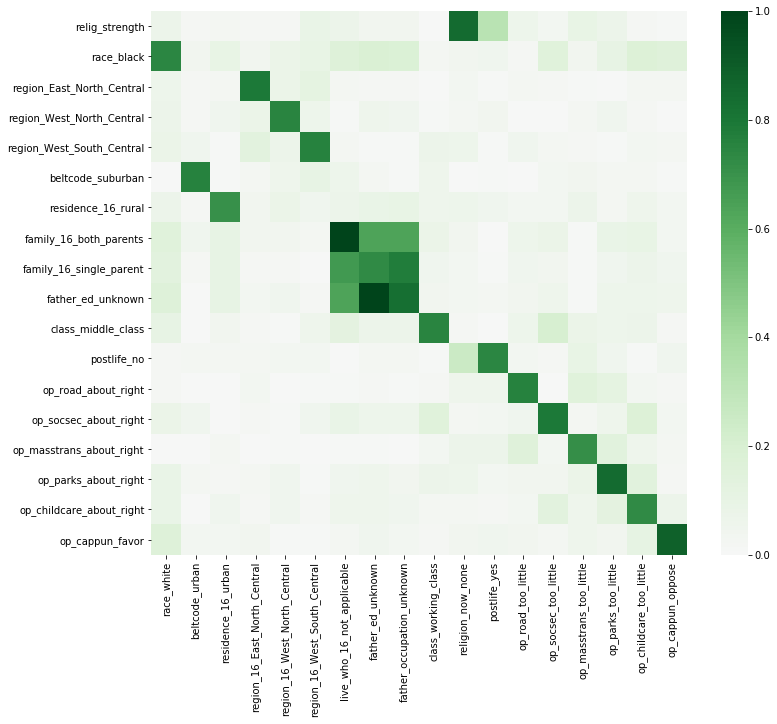

In [115]:
plt.figure(figsize=(12, 10))
sns.heatmap(most_collinear,
           cmap='PRGn',
           center=0)
plt.show()

In [116]:
## Drop things on x axis

## live_who_16_not_applicable is because it's the same as living with both parents - remove.

## Region at 16 very correlated with region now
## Could do a variable to see whether it has changed
## This is already covered in geo mobility
## Drop region at 16 for variables mentioned

## Also drop one answer to each opinion question
## Covered via other answers

## Same for religion now = none
## Same for beltcode urban
## Same for residence 16 urban
## Same for race white
## Same for father ed unknown and father occ unknown
## Same for working class

x_train.drop(columns=collinear_features, inplace=True)
x_validation.drop(columns=collinear_features, inplace=True)
x_test.drop(columns=collinear_features, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


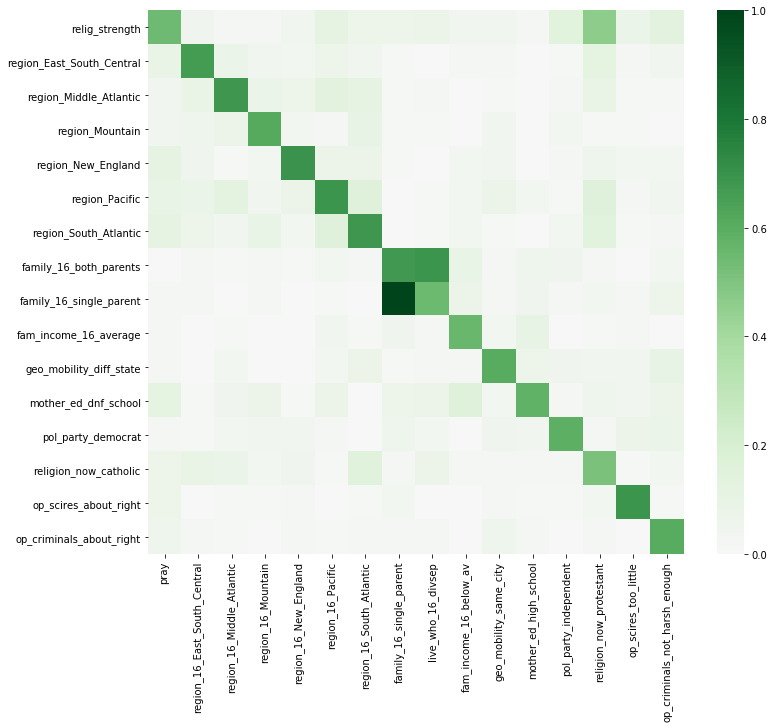

In [117]:
## Could drop variables up to 0.5 correlation
## Leave for now

corr_matrix2 = x_train.corr().abs()
upper2 = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k=1).astype(np.bool))
lower2 = corr_matrix2.where(np.tril(np.ones(corr_matrix2.shape), k=-1).astype(np.bool))
collinear_features2 = [column for column in upper2.columns if any(upper2[column] > 0.50)]
collinear_features2a = [column for column in lower2.columns if any(lower2[column] > 0.50)]
most_collinear2 = corr_matrix2.loc[collinear_features2a, collinear_features2]
plt.figure(figsize=(12, 10))
sns.heatmap(most_collinear2,
           cmap='PRGn',
           center=0)
plt.show()

In [118]:
x_train.shape

(2658, 177)

In [119]:
y_train.sum()

894

## Transform continuous variables to be normal shaped

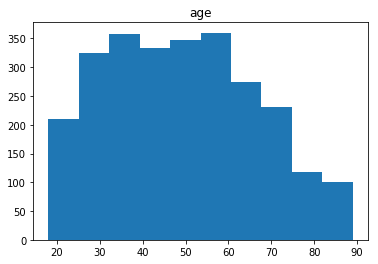

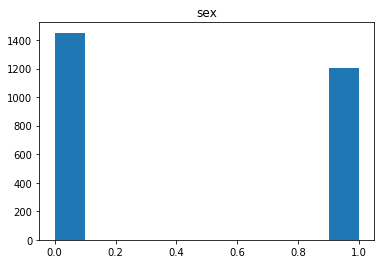

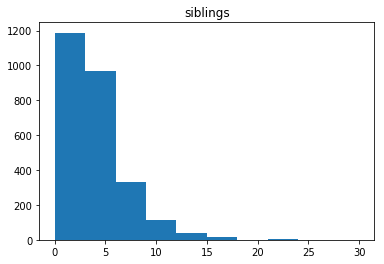

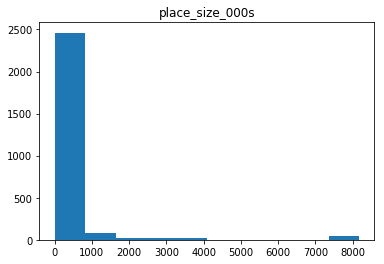

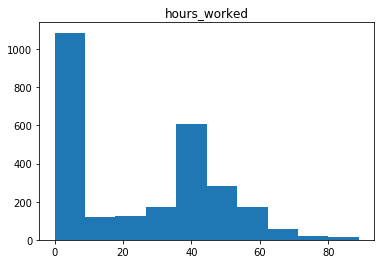

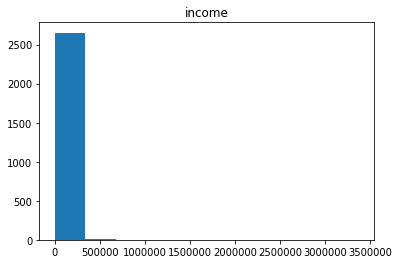

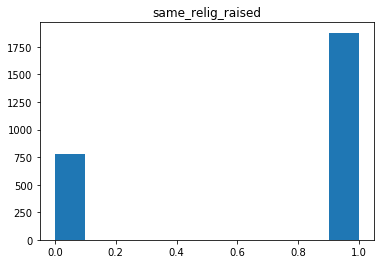

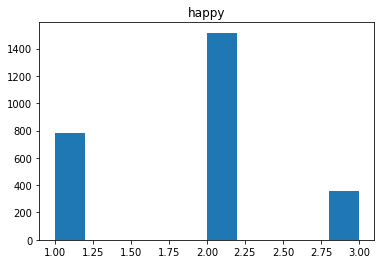

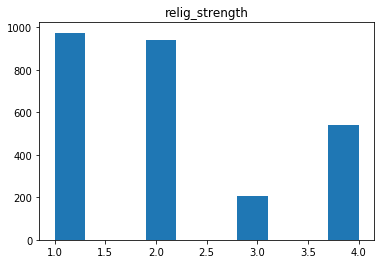

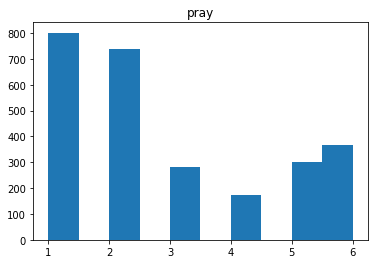

In [120]:
## View continuous variable shapes

for i in np.arange(0, 10):
    plt.hist(x_train.iloc[:, i])
    plt.title(x_train.columns[i])
    plt.show()

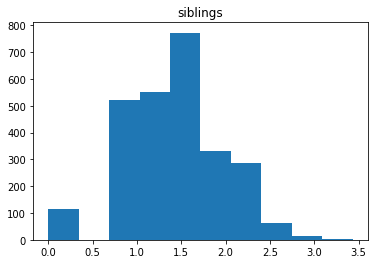

In [121]:
## This looks better

plt.hist(np.log(x_train.loc[:, 'siblings']+1))
plt.title('siblings')
plt.show()

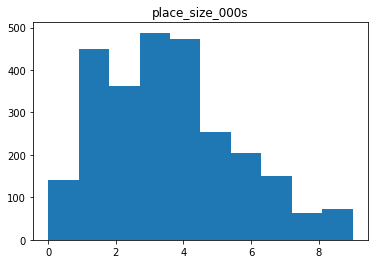

In [122]:
## This looks better

plt.hist(np.log(x_train.loc[:, 'place_size_000s']+1))
plt.title('place_size_000s')
plt.show()

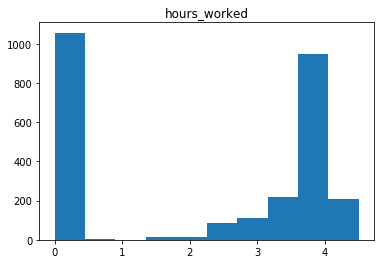

In [123]:
## This does not look better

plt.hist(np.log(x_train.loc[:, 'hours_worked']+1))
plt.title('hours_worked')
plt.show()

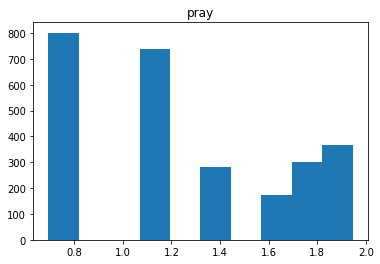

In [124]:
## This does not look better

plt.hist(np.log(x_train.loc[:, 'pray']+1))
plt.title('pray')
plt.show()

In [125]:
## Tranforms to include:

x_train['siblings_log'] = np.log(x_train['siblings']+1)
x_train['place_size_000s_log'] = np.log(x_train['place_size_000s']+1)
x_train.drop(columns=['siblings', 'place_size_000s'], inplace=True)

x_validation['siblings_log'] = np.log(x_validation['siblings']+1)
x_validation['place_size_000s_log'] = np.log(x_validation['place_size_000s']+1)
x_validation.drop(columns=['siblings', 'place_size_000s'], inplace=True)

x_test['siblings_log'] = np.log(x_test['siblings']+1)
x_test['place_size_000s_log'] = np.log(x_test['place_size_000s']+1)
x_test.drop(columns=['siblings', 'place_size_000s'], inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [126]:
x_train.head()

,age,sex,hours_worked,income,same_relig_raised,happy,relig_strength,pray,race_american_indian,race_black,...,op_scires_too_little,op_scires_too_much,op_cappun_dont_know,op_cappun_favor,op_criminals_about_right,op_criminals_dont_know,op_criminals_not_harsh_enough,op_criminals_too_harsh,siblings_log,place_size_000s_log
1383,45.0,0,40.0,45000.000000,1,2.0,2.0,1.0,0,0,...,0,1,0,1,0,1,0,0,0.693147,2.890372
3813,87.0,0,0.0,26706.776646,0,2.0,4.0,2.0,0,0,...,0,0,0,1,0,0,1,0,1.386294,2.833213
1594,65.0,1,0.0,37500.000000,1,2.0,2.0,4.0,0,0,...,0,0,0,1,0,0,1,0,1.791759,1.386294
2721,60.0,1,0.0,45000.000000,1,2.0,2.0,5.0,0,0,...,0,0,0,1,0,0,1,0,1.386294,3.761200
2556,62.0,0,0.0,9000.000000,0,2.0,1.0,1.0,0,0,...,0,0,0,1,0,0,1,0,2.197225,2.890372


### Correlations with outcome in training data

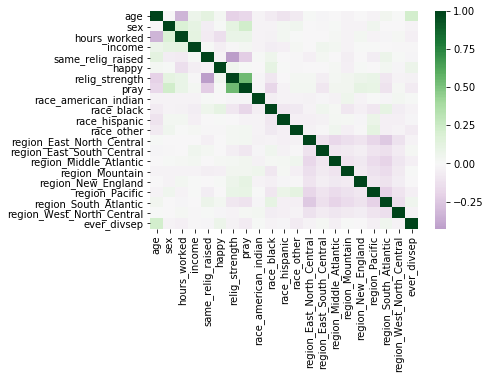

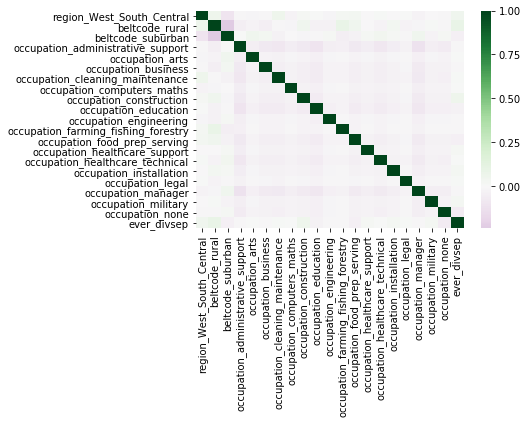

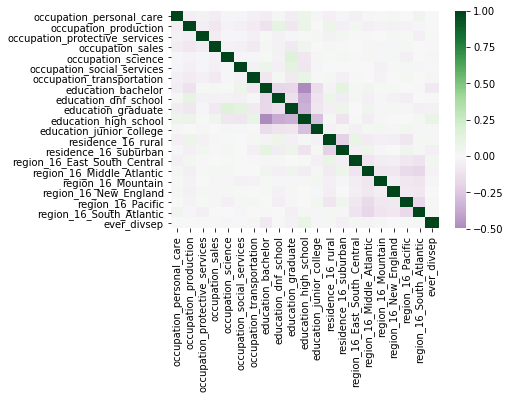

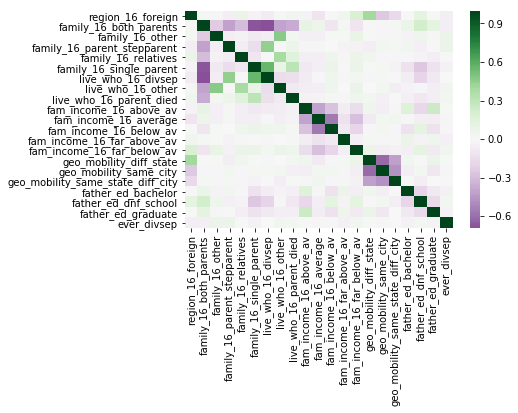

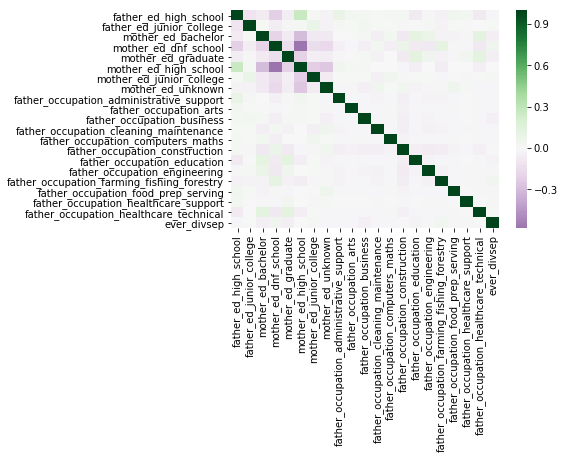

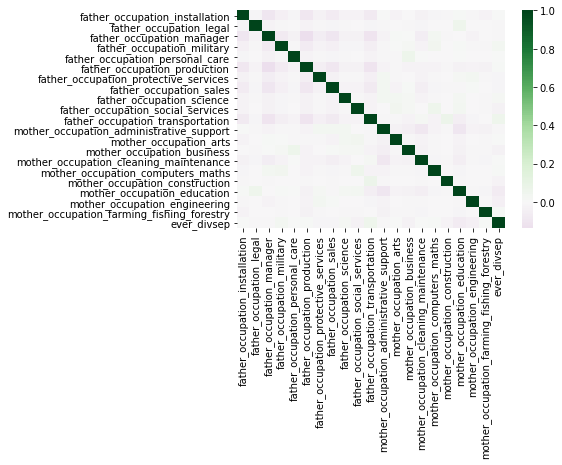

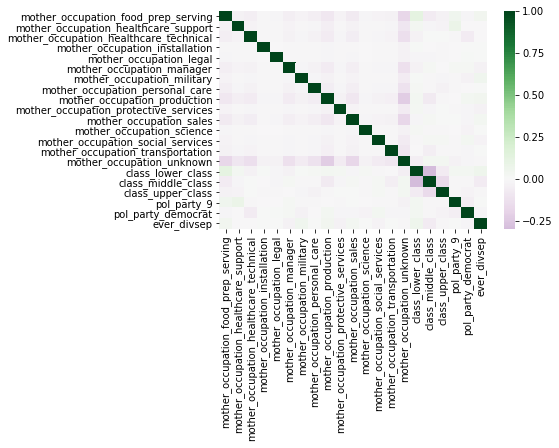

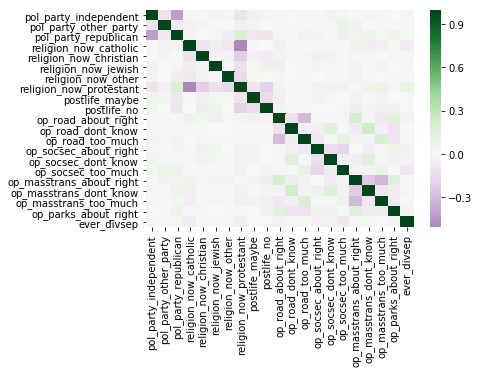

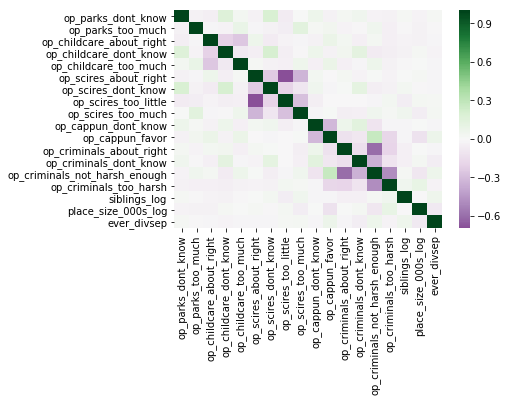

In [229]:
cols = len(x_train.columns)
charts = int(round(cols / 20, 0))

for chart in np.arange(0, charts):
    corr1 = pd.concat([x_train.iloc[:, (chart*20):((chart+1)*20)], y_train], axis=1)
    corr1mat = corr1.corr()
    sns.heatmap(corr1mat, cmap='PRGn', center=0)
    plt.show()

## Data variations

### Scaling

#### StandardScaler
This is a standardization scaler - all variables mean 0 var 1.

In [127]:
standard_scaler = preprocessing.StandardScaler().fit(x_train)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [128]:
standard_scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [129]:
x_train_ss = standard_scaler.transform(x_train)
x_validation_ss = standard_scaler.transform(x_validation)
x_test_ss = standard_scaler.transform(x_test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


#### MinMaxScaler
This is a normalization scaler - all variables in range 0 to 1.

In [130]:
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [131]:
min_max_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [132]:
x_train_mm = min_max_scaler.transform(x_train)
x_validation_mm = min_max_scaler.transform(x_validation)
x_test_mm = min_max_scaler.transform(x_test)

## PCA

#### StandardScaler data

In [133]:
pca_ss = PCA()
pca_ss.fit(x_train_ss)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [134]:
pca_ss.explained_variance_[:10]

array([5.10056404, 3.86805361, 3.48686521, 2.88681639, 2.58313342,
       2.4050738 , 2.32704859, 2.22446047, 2.18331023, 2.12822967])

In [135]:
sum(pca_ss.explained_variance_ > 1)

80

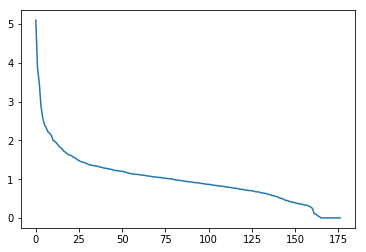

In [136]:
plt.plot(pca_ss.explained_variance_)
plt.show()

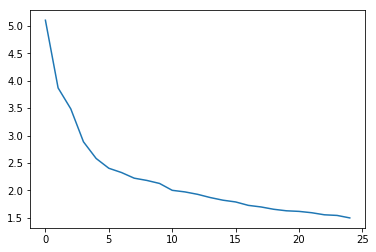

In [137]:
plt.plot(pca_ss.explained_variance_[:25])
plt.show()

In [138]:
## drastic change at point 5 - keep only 5?

##pca_ss = PCA(n_components = 5)
##pca_ss.fit(x_train_ss)
##x_train_ss_pca = pca_ss.transform(x_train_ss)
##x_validation_ss_pca = pca_ss.transform(x_validation_ss)
##x_test_ss_pca = pca_ss.transform(x_test_ss)

#### MinMaxScaler data

In [139]:
pca_mm = PCA()
pca_mm.fit(x_train_mm)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [140]:
pca_mm.explained_variance_[:10]

array([0.68485119, 0.61791086, 0.56507541, 0.46441478, 0.45066213,
       0.40777053, 0.36815298, 0.34138872, 0.33068333, 0.31989953])

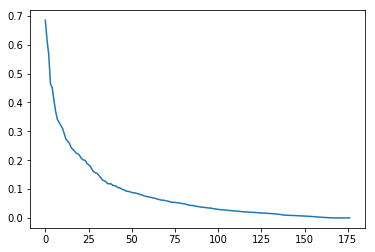

In [141]:
plt.plot(pca_mm.explained_variance_)
plt.show()

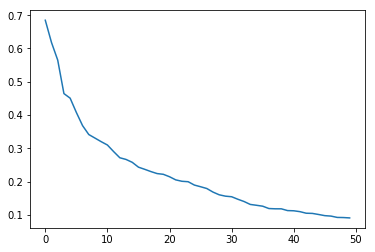

In [142]:
plt.plot(pca_mm.explained_variance_[:50])
plt.show()

In [143]:
## Changes after about 11? Or maybe 27?

##pca_mm = PCA(n_components=11)
##pca_mm.fit(x_train_mm)
##x_train_mm_pca = pca_mm.transform(x_train_mm)
##x_validation_mm_pca = pca_mm.transform(x_validation_mm)
##x_test_mm_pca = pca_mm.transform(x_test_mm)

## Cross validation to find best hyperparameters

### KNN

In [153]:
knn = KNeighborsClassifier()
knn_param_grid = {'weights': ['uniform', 'distance'],
                  'n_neighbors': np.arange(1, 51)}

In [154]:
start = time.process_time()

datasets = {'normal': x_train, 
            'standard_scaler': x_train_ss, 
            'min_max_scaler': x_train_mm}
scoring_types = ['accuracy', 'f1']
knn_results_all = pd.DataFrame()
knn_results_summary = pd.DataFrame()
knn_dataset = []
knn_dataset_smy = []
knn_scoring = []
knn_scoring_smy = []
knn_n = []
knn_w = []
knn_score = []
knn_std = []
knn_best_params = []

for dataset in datasets:
    for scoring_type in scoring_types:
        knn_model = GridSearchCV(estimator=knn,
                                 param_grid=knn_param_grid,
                                 scoring=scoring_type,
                                 cv=5,
                                 verbose=10,
                                 n_jobs=2)
        knn_model.fit(datasets[dataset], y_train)
        knn_dataset_smy.append(dataset)
        knn_scoring_smy.append(scoring_type)
        knn_best_params.append(knn_model.best_params_)
        for i in np.arange(0, len(knn_model.cv_results_['params'])):
            knn_dataset.append(dataset)
            knn_scoring.append(scoring_type)
            knn_n.append(knn_model.cv_results_['params'][i]['n_neighbors'])
            knn_w.append(knn_model.cv_results_['params'][i]['weights'])
            knn_score.append(knn_model.cv_results_['mean_test_score'][i])
            knn_std.append(knn_model.cv_results_['std_test_score'][i])

knn_results_summary['dataset'] = knn_dataset_smy
knn_results_summary['scoring'] = knn_scoring_smy
knn_results_summary['best_params'] = knn_best_params
                           
knn_results_all['dataset'] = knn_dataset
knn_results_all['scoring'] = knn_scoring
knn_results_all['neighbors'] = knn_n
knn_results_all['weights'] = knn_w
knn_results_all['score'] = knn_score
knn_results_all['std'] = knn_std

print(time.process_time() - start)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   13.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   17.0s
[Parallel(

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1923s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  52 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done 110 tasks      | elapsed:   10.4s
[Parallel(n_jobs=2)]: Done 132 tasks      | elapsed:   12.4s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   15.4s
[Parallel(n_jobs=2)]: Done 184 tasks      | elapsed:   18.0s
[Parallel(n_jobs=2)]: Done 214 tasks      | elapsed:   21.2s
[Parallel(n_jobs=2)]: Done 244 tasks      | elapsed:   24.2s
[Parallel(n_jobs=2)]: Done 278 tasks      | elapsed:   28.2s
[Pa

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   16.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   22.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   32.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   40.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   51.4s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Do

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   15.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   21.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   32.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   40.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   52.0s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Do

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   16.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   23.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   32.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   40.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   52.4s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Do

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   18.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   25.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   35.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   43.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   55.4s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Do

12.136353999999756


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  8.4min finished


In [155]:
knn_results_summary

,dataset,scoring,best_params
0,normal,accuracy,"{'n_neighbors': 26, 'weights': 'uniform'}"
1,normal,f1,"{'n_neighbors': 1, 'weights': 'uniform'}"
2,standard_scaler,accuracy,"{'n_neighbors': 50, 'weights': 'distance'}"
3,standard_scaler,f1,"{'n_neighbors': 1, 'weights': 'uniform'}"
4,min_max_scaler,accuracy,"{'n_neighbors': 47, 'weights': 'uniform'}"
5,min_max_scaler,f1,"{'n_neighbors': 1, 'weights': 'uniform'}"


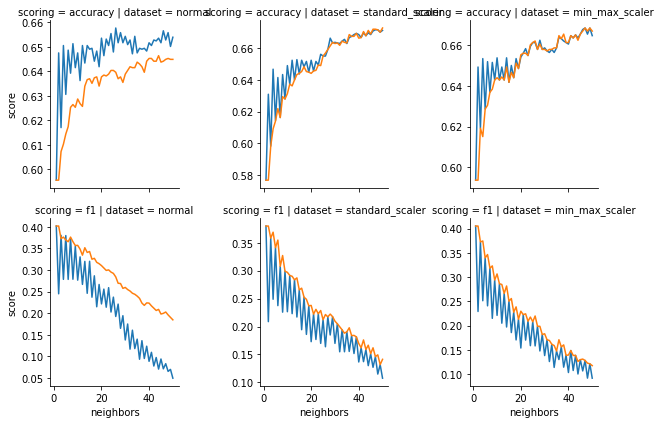

In [156]:
g = sns.FacetGrid(knn_results_all, 
                  row='scoring', 
                  col='dataset', 
                  hue='weights',
                  sharey=False)
g = g.map(sns.lineplot, 'neighbors', 'score')
plt.show()

### Gaussian Naive Bayes

In [157]:
gnb = GaussianNB()
gnb_param_grid = {'var_smoothing': [1e-09, 1e-08, 1e-07]}

In [158]:
start = time.process_time()

datasets = {'normal': x_train, 
            'standard_scaler': x_train_ss, 
            'min_max_scaler': x_train_mm}
scoring_types = ['accuracy', 'f1']
gnb_results_all = pd.DataFrame()
gnb_results_summary = pd.DataFrame()
gnb_dataset = []
gnb_dataset_smy = []
gnb_scoring = []
gnb_scoring_smy = []
gnb_v = []
gnb_score = []
gnb_std = []
gnb_best_params = []

for dataset in datasets:
    for scoring_type in scoring_types:
        gnb_model = GridSearchCV(estimator=gnb,
                                 param_grid=gnb_param_grid,
                                 scoring=scoring_type,
                                 cv=5,
                                 verbose=10)
        gnb_model.fit(datasets[dataset], y_train)
        gnb_dataset_smy.append(dataset)
        gnb_scoring_smy.append(scoring_type)
        gnb_best_params.append(gnb_model.best_params_)
        for i in np.arange(0, len(gnb_model.cv_results_['params'])):
            gnb_dataset.append(dataset)
            gnb_scoring.append(scoring_type)
            gnb_v.append(gnb_model.cv_results_['params'][i]['var_smoothing'])
            gnb_score.append(gnb_model.cv_results_['mean_test_score'][i])
            gnb_std.append(gnb_model.cv_results_['std_test_score'][i])

gnb_results_summary['dataset'] = gnb_dataset_smy
gnb_results_summary['scoring'] = gnb_scoring_smy
gnb_results_summary['best_params'] = gnb_best_params
                           
gnb_results_all['dataset'] = gnb_dataset
gnb_results_all['scoring'] = gnb_scoring
gnb_results_all['var_smoothing'] = gnb_v
gnb_results_all['score'] = gnb_score  
gnb_results_all['std'] = gnb_std

print(time.process_time() - start)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] var_smoothing=1e-09 .............................................
[CV] .... var_smoothing=1e-09, score=0.6090225563909775, total=   0.0s
[CV] var_smoothing=1e-09 .............................................
[CV] .... var_smoothing=1e-09, score=0.6015037593984962, total=   0.0s
[CV] var_smoothing=1e-09 .............................................
[CV] .... var_smoothing=1e-09, score=0.6710526315789473, total=   0.0s
[CV] var_smoothing=1e-09 .............................................
[CV] ..... var_smoothing=1e-09, score=0.631578947368421, total=   0.0s
[CV] var_smoothing=1e-09 .............................................
[CV] .... var_smoothing=1e-09, score=0.6150943396226415, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.6071428571428571, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV] .... var_smoothing=1e-08, score=0.6113207547169811, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.5469924812030075, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.5300751879699248, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.6635338345864662, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.5601503759398496, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.5415094339622641, total=   0.0s
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] var_smoothing=1e-09 .............................................
[CV] .... var_smoothing=1e-09, score=0.5418502202643173, total=   0.0s
[CV] var_smoothin

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s


[CV] .... var_smoothing=1e-09, score=0.5585585585585586, total=   0.0s
[CV] var_smoothing=1e-09 .............................................
[CV] .... var_smoothing=1e-09, score=0.5584415584415584, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.5446623093681917, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.5583333333333332, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.2085308056872038, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.5446428571428571, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.5579399141630901, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


[CV] ................. var_smoothing=1e-07, score=0.532, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.5299806576402321, total=   0.0s
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] var_smoothing=1e-09 .............................................
[CV] ... var_smoothing=1e-09, score=0.42857142857142855, total=   0.0s
[CV] var_smoothing=1e-09 .............................................
[CV] .... var_smoothing=1e-09, score=0.4116541353383459, total=   0.0s
[CV] var_smoothing=1e-09 .............................................
[CV] ... var_smoothing=1e-09, score=0.40601503759398494, total=   0.0s
[CV] var_smoothing=1e-09 .............................................
[CV] ... var_smoothing=1e-09, score=0.38345864661654133, total=   0.0s
[CV] var_smoothing=1e-09 .............................................
[CV] ... var_smoothing=1e-09, score=0.37735849056603776, total=   0.0s
[CV] var_smoothin

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... var_smoothing=1e-08, score=0.38113207547169814, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] ... var_smoothing=1e-07, score=0.44548872180451127, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.4191729323308271, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] ... var_smoothing=1e-07, score=0.41353383458646614, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.4041353383458647, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.3905660377358491, total=   0.0s
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] var_smoothing=1e-09 .............................................
[CV] .... var_smoothing=1e-09, score=0.5205047318611986, total=   0.0s
[CV] var_smoothin

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV] .... var_smoothing=1e-08, score=0.4935064935064935, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.4784688995215311, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.5075075075075075, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.5171849427168576, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] ..... var_smoothing=1e-07, score=0.507177033492823, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.4935064935064935, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] ... var_smoothing=1e-07, score=0.48287112561174544, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV] .... var_smoothing=1e-08, score=0.4342105263157895, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] ... var_smoothing=1e-08, score=0.42105263157894735, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] ... var_smoothing=1e-08, score=0.42105263157894735, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] ... var_smoothing=1e-08, score=0.41132075471698115, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] ... var_smoothing=1e-07, score=0.45300751879699247, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.4398496240601504, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] ... var_smoothing=1e-07, score=0.43796992481203006, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV] .... var_smoothing=1e-08, score=0.5205930807248764, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.5121555915721232, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] ... var_smoothing=1e-08, score=0.49342105263157887, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] ... var_smoothing=1e-08, score=0.49006622516556286, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .... var_smoothing=1e-08, score=0.5078864353312302, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.5109243697478991, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .... var_smoothing=1e-07, score=0.5130718954248367, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished


In [159]:
gnb_results_summary

,dataset,scoring,best_params
0,normal,accuracy,{'var_smoothing': 1e-09}
1,normal,f1,{'var_smoothing': 1e-09}
2,standard_scaler,accuracy,{'var_smoothing': 1e-07}
3,standard_scaler,f1,{'var_smoothing': 1e-09}
4,min_max_scaler,accuracy,{'var_smoothing': 1e-07}
5,min_max_scaler,f1,{'var_smoothing': 1e-07}


In [160]:
gnb_results_all

,dataset,scoring,var_smoothing,score,std
0,normal,accuracy,1.000000e-09,0.625658,0.024776
1,normal,accuracy,1.000000e-08,0.624530,0.031188
2,normal,accuracy,1.000000e-07,0.568473,0.048528
3,normal,f1,1.000000e-09,0.520715,0.065552
4,normal,f1,1.000000e-08,0.482765,0.137314
5,normal,f1,1.000000e-07,0.420335,0.210325
6,standard_scaler,accuracy,1.000000e-09,0.401430,0.018782
7,standard_scaler,accuracy,1.000000e-08,0.405192,0.020609
8,standard_scaler,accuracy,1.000000e-07,0.414597,0.018234
9,standard_scaler,f1,1.000000e-09,0.504051,0.014475


### Random Forest

In [230]:
rfc = RandomForestClassifier(random_state=5322, class_weight='balanced')
rfc_param_grid = {'n_estimators': [10, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [4, 7, 10, None],
                  'max_features': [7, 15, 25, None]}

In [231]:
start = time.process_time()

datasets = {'normal': x_train, 
            'standard_scaler': x_train_ss, 
            'min_max_scaler': x_train_mm}
scoring_types = ['accuracy', 'f1']
rfc_results_all = pd.DataFrame()
rfc_results_summary = pd.DataFrame()
rfc_dataset = []
rfc_dataset_smy = []
rfc_scoring = []
rfc_scoring_smy = []
rfc_n = []
rfc_c = []
rfc_md = []
rfc_mf = []
rfc_score = []
rfc_std = []
rfc_best_params = []

for dataset in datasets:
    for scoring_type in scoring_types:
        rfc_model = GridSearchCV(estimator=rfc,
                                 param_grid=rfc_param_grid,
                                 scoring=scoring_type,
                                 cv=5,
                                 verbose=10,
                                 n_jobs=2)
        rfc_model.fit(datasets[dataset], y_train)
        rfc_dataset_smy.append(dataset)
        rfc_scoring_smy.append(scoring_type)
        rfc_best_params.append(rfc_model.best_params_)
        for i in np.arange(0, len(rfc_model.cv_results_['params'])):
            rfc_dataset.append(dataset)
            rfc_scoring.append(scoring_type)
            rfc_n.append(rfc_model.cv_results_['params'][i]['n_estimators'])
            rfc_c.append(rfc_model.cv_results_['params'][i]['criterion'])
            rfc_md.append(rfc_model.cv_results_['params'][i]['max_depth'])
            rfc_mf.append(rfc_model.cv_results_['params'][i]['max_features'])
            rfc_score.append(rfc_model.cv_results_['mean_test_score'][i])
            rfc_std.append(rfc_model.cv_results_['std_test_score'][i])

rfc_results_summary['dataset'] = rfc_dataset_smy
rfc_results_summary['scoring'] = rfc_scoring_smy
rfc_results_summary['best_params'] = rfc_best_params
                           
rfc_results_all['dataset'] = rfc_dataset
rfc_results_all['scoring'] = rfc_scoring
rfc_results_all['n_estimators'] = rfc_n
rfc_results_all['criterion'] = rfc_c
rfc_results_all['max_depth'] = rfc_md
rfc_results_all['max_features'] = rfc_mf
rfc_results_all['score'] = rfc_score  
rfc_results_all['std'] = rfc_std

print(time.process_time() - start)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1917s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  54 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  76 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done  98 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Batch computation too slow (2.0013s.) Setting batch_size=1.
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   14.4s
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:   16.0s
[Parallel(n_jobs=2)]: Done 15

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0388s.) Setting batch_size=10.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  54 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Batch computation too slow (2.2476s.) Setting batch_size=5.
[Parallel(n_jobs=2)]: Done  99 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Batch computation too slow (2.2622s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Batch computation too slow (3.7593s.) Setting batch_size=1.
[Parallel(n_jobs=2)]: Done 122 tasks      | elapsed:   12.4s
[Parallel(n_jobs=2)]: Done 129 tasks      | elapsed:   13.6s
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:   14.2s
[Parallel(n_jobs=2)]: Done 151 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Done 162 tasks      | elapsed:   16.4s
[Parallel(n_jobs=2)]: Done 173 tasks      | ela

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0428s.) Setting batch_size=8.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  84 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Batch computation too slow (2.1162s.) Setting batch_size=4.
[Parallel(n_jobs=2)]: Batch computation too slow (2.6378s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Batch computation too slow (3.8637s.) Setting batch_size=1.
[Parallel(n_jobs=2)]: Done 120 tasks      | elapsed:   13.7s
[Parallel(n_jobs=2)]: Done 128 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done 140 tasks      | elapsed:   15.7s
[Parallel(n_jobs=2)]: Done 149 tasks      | elapsed:   16.8s
[Parallel(n_jobs=2)]: Done 160 tasks      | elapsed:   17.6s
[Parallel(n_jobs=2)]: Done 171 tasks      | elap

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0714s.) Setting batch_size=4.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  72 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Batch computation too slow (2.3823s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done  96 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done 114 tasks      | elapsed:   12.0s
[Parallel(n_jobs=2)]: Batch computation too slow (2.0443s.) Setting batch_size=1.
[Parallel(n_jobs=2)]: Done 128 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Done 140 tasks      | elapsed:   16.4s
[Parallel(n_jobs=2)]: Done 151 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:   19.1s
[Paralle

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0435s.) Setting batch_size=8.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  84 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Batch computation too slow (2.1458s.) Setting batch_size=4.
[Parallel(n_jobs=2)]: Batch computation too slow (5.5383s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done 128 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Batch computation too slow (2.2902s.) Setting batch_size=1.
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   16.3s
[Parallel(n_jobs=2)]: Done 150 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done 159 tasks      | elapsed:   18.4s
[Parallel(n_jobs=2)]: Done 170 tasks      | elapsed:   20.5s
[Parallel(n_jobs=2)]: Done 181 tasks      | elap

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0505s.) Setting batch_size=6.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Batch computation too slow (2.1850s.) Setting batch_size=3.
[Parallel(n_jobs=2)]: Done  97 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done 118 tasks      | elapsed:   15.2s
[Parallel(n_jobs=2)]: Batch computation too slow (2.3280s.) Setting batch_size=1.
[Parallel(n_jobs=2)]: Done 133 tasks      | elapsed:   16.2s
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed:   16.6s
[Parallel(n_jobs=2)]: Done 153 tasks      | elapsed:   17.7s
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:   19.1s
[Parallel(n_jobs=2)]: Done 177 tasks      | elapsed:   24.2s
[Paralle

20.618610999999873


In [232]:
rfc_results_summary

,dataset,scoring,best_params
0,normal,accuracy,"{'criterion': 'entropy', 'max_depth': None, 'm..."
1,normal,f1,"{'criterion': 'entropy', 'max_depth': 4, 'max_..."
2,standard_scaler,accuracy,"{'criterion': 'entropy', 'max_depth': None, 'm..."
3,standard_scaler,f1,"{'criterion': 'entropy', 'max_depth': 4, 'max_..."
4,min_max_scaler,accuracy,"{'criterion': 'entropy', 'max_depth': None, 'm..."
5,min_max_scaler,f1,"{'criterion': 'entropy', 'max_depth': 4, 'max_..."


In [320]:
rfc_results_all.loc[(rfc_results_all['dataset'] == 'normal') & (rfc_results_all['scoring'] == 'f1'), ].sort_values(['score'], ascending=False)

,dataset,scoring,n_estimators,criterion,max_depth,max_features,score,std
154,normal,f1,50,entropy,4.0,NaN,0.581127,0.008846
155,normal,f1,100,entropy,4.0,NaN,0.579660,0.010847
106,normal,f1,50,gini,4.0,NaN,0.578667,0.011815
107,normal,f1,100,gini,4.0,NaN,0.578300,0.011408
153,normal,f1,10,entropy,4.0,NaN,0.576247,0.011168
167,normal,f1,100,entropy,7.0,NaN,0.573951,0.010557
166,normal,f1,50,entropy,7.0,NaN,0.571043,0.010684
105,normal,f1,10,gini,4.0,NaN,0.569948,0.010291
119,normal,f1,100,gini,7.0,NaN,0.568467,0.019453
165,normal,f1,10,entropy,7.0,NaN,0.565752,0.011837


#### Randomized version

In [234]:
rfc_2 = RandomForestClassifier(random_state=5322, class_weight='balanced')
rfc_param_2 = {'n_estimators': sp_randint(10, 200),
                  'criterion': ['gini', 'entropy'],
                  'max_depth': sp_randint(3, 50),
                  'max_features': sp_randint(5, 25)}

In [235]:
start = time.process_time()

n_iter_search = 100
datasets = {'normal': x_train, 
            'standard_scaler': x_train_ss, 
            'min_max_scaler': x_train_mm}
scoring_types = ['accuracy', 'f1']
rfc2_results_all = pd.DataFrame()
rfc2_results_summary = pd.DataFrame()
rfc_dataset = []
rfc_dataset_smy = []
rfc_scoring = []
rfc_scoring_smy = []
rfc_n = []
rfc_c = []
rfc_md = []
rfc_mf = []
rfc_score = []
rfc_std = []
rfc_best_params = []

for dataset in datasets:
    for scoring_type in scoring_types:
        rfc_model = RandomizedSearchCV(estimator=rfc_2,
                                       param_distributions=rfc_param_2,
                                       n_iter=n_iter_search,
                                       scoring=scoring_type,
                                       cv=5,
                                       random_state=5322, #5322
                                       verbose=10,
                                       n_jobs=2)
        rfc_model.fit(datasets[dataset], y_train)
        rfc_dataset_smy.append(dataset)
        rfc_scoring_smy.append(scoring_type)
        rfc_best_params.append(rfc_model.best_params_)
        for i in np.arange(0, len(rfc_model.cv_results_['params'])):
            rfc_dataset.append(dataset)
            rfc_scoring.append(scoring_type)
            rfc_n.append(rfc_model.cv_results_['params'][i]['n_estimators'])
            rfc_c.append(rfc_model.cv_results_['params'][i]['criterion'])
            rfc_md.append(rfc_model.cv_results_['params'][i]['max_depth'])
            rfc_mf.append(rfc_model.cv_results_['params'][i]['max_features'])
            rfc_score.append(rfc_model.cv_results_['mean_test_score'][i])
            rfc_std.append(rfc_model.cv_results_['std_test_score'][i])

rfc2_results_summary['dataset'] = rfc_dataset_smy
rfc2_results_summary['scoring'] = rfc_scoring_smy
rfc2_results_summary['best_params'] = rfc_best_params
                           
rfc2_results_all['dataset'] = rfc_dataset
rfc2_results_all['scoring'] = rfc_scoring
rfc2_results_all['n_estimators'] = rfc_n
rfc2_results_all['criterion'] = rfc_c
rfc2_results_all['max_depth'] = rfc_md
rfc2_results_all['max_features'] = rfc_mf
rfc2_results_all['score'] = rfc_score  
rfc2_results_all['std'] = rfc_std

print(time.process_time() - start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.8s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   15.5s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   19.2s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   22.7s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   24.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   29.5s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   34.5s
[Parallel(

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   22.3s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   25.6s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   27.8s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   31.0s
[Parallel(

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.4s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   14.2s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   20.0s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   24.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   27.9s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   31.8s
[Parallel(

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   18.8s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   21.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   24.1s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   27.8s
[Parallel(

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   17.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   20.2s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   23.4s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   25.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   27.6s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   31.6s
[Parallel(

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   15.7s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   19.9s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   26.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   29.6s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   35.4s
[Parallel(

16.326658000000407


In [236]:
rfc2_results_summary

,dataset,scoring,best_params
0,normal,accuracy,"{'criterion': 'entropy', 'max_depth': 22, 'max..."
1,normal,f1,"{'criterion': 'gini', 'max_depth': 4, 'max_fea..."
2,standard_scaler,accuracy,"{'criterion': 'gini', 'max_depth': 40, 'max_fe..."
3,standard_scaler,f1,"{'criterion': 'gini', 'max_depth': 6, 'max_fea..."
4,min_max_scaler,accuracy,"{'criterion': 'gini', 'max_depth': 34, 'max_fe..."
5,min_max_scaler,f1,"{'criterion': 'entropy', 'max_depth': 4, 'max_..."


In [322]:
rfc2_results_all.loc[(rfc2_results_all['scoring'] == 'f1'), ].sort_values(['score'], ascending=False)

,dataset,scoring,n_estimators,criterion,max_depth,max_features,score,std
115,normal,f1,98,gini,4,22,0.558824,0.020470
537,min_max_scaler,f1,181,entropy,4,16,0.558253,0.024632
596,min_max_scaler,f1,175,entropy,8,24,0.556522,0.007171
125,normal,f1,188,gini,4,17,0.556060,0.013846
395,standard_scaler,f1,156,gini,6,14,0.553981,0.017191
515,min_max_scaler,f1,68,gini,3,16,0.553848,0.017948
309,standard_scaler,f1,187,entropy,8,20,0.552246,0.014168
100,normal,f1,164,entropy,8,17,0.552134,0.010850
581,min_max_scaler,f1,82,gini,6,17,0.547978,0.022246
384,standard_scaler,f1,134,gini,7,24,0.547800,0.005016


### Gradient Boosting

In [238]:
gbc = GradientBoostingClassifier(random_state=5322)
gbc_param_grid = {'loss': ['deviance', 'exponential'],
                  'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
                  'max_depth': [4, 7, 10],
                  'max_features': [10, 50, None]}

In [240]:
start = time.process_time()

datasets = {'normal': x_train, 
            'standard_scaler': x_train_ss, 
            'min_max_scaler': x_train_mm}
scoring_types = ['accuracy', 'f1']
gbc_results_all = pd.DataFrame()
gbc_results_summary = pd.DataFrame()
gbc_dataset = []
gbc_dataset_smy = []
gbc_scoring = []
gbc_scoring_smy = []
gbc_loss = []
gbc_lr = []
gbc_md = []
gbc_mf = []
gbc_score = []
gbc_std = []
gbc_best_params = []

for dataset in datasets:
    for scoring_type in scoring_types:
        gbc_model = GridSearchCV(estimator=gbc,
                                 param_grid=gbc_param_grid,
                                 scoring=scoring_type,
                                 cv=5,
                                 verbose=10,
                                 n_jobs=2)
        gbc_model.fit(datasets[dataset], y_train)
        gbc_dataset_smy.append(dataset)
        gbc_scoring_smy.append(scoring_type)
        gbc_best_params.append(gbc_model.best_params_)
        for i in np.arange(0, len(gbc_model.cv_results_['params'])):
            gbc_dataset.append(dataset)
            gbc_scoring.append(scoring_type)
            gbc_loss.append(gbc_model.cv_results_['params'][i]['loss'])
            gbc_lr.append(gbc_model.cv_results_['params'][i]['learning_rate'])
            gbc_md.append(gbc_model.cv_results_['params'][i]['max_depth'])
            gbc_mf.append(gbc_model.cv_results_['params'][i]['max_features'])
            gbc_score.append(gbc_model.cv_results_['mean_test_score'][i])
            gbc_std.append(gbc_model.cv_results_['std_test_score'][i])

gbc_results_summary['dataset'] = gbc_dataset_smy
gbc_results_summary['scoring'] = gbc_scoring_smy
gbc_results_summary['best_params'] = gbc_best_params
                           
gbc_results_all['dataset'] = gbc_dataset
gbc_results_all['scoring'] = gbc_scoring
gbc_results_all['loss'] = gbc_loss
gbc_results_all['learning_rate'] = gbc_lr
gbc_results_all['max_depth'] = gbc_md
gbc_results_all['max_features'] = gbc_mf
gbc_results_all['score'] = gbc_score  
gbc_results_all['std'] = gbc_std

print(time.process_time() - start)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   12.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   24.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   35.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  3.3min
[Parallel(

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   22.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   34.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  3.4min
[Parallel(

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   24.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   36.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  4.5min
[Parallel(

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   11.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   23.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   35.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  3.2min
[Parallel(

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   10.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   23.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   35.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  3.8min
[Parallel(

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   23.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   35.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  5.5min
[Parallel(

19.66501799999969


In [241]:
gbc_results_summary

,dataset,scoring,best_params
0,normal,accuracy,"{'learning_rate': 0.1, 'loss': 'deviance', 'ma..."
1,normal,f1,"{'learning_rate': 0.2, 'loss': 'deviance', 'ma..."
2,standard_scaler,accuracy,"{'learning_rate': 0.1, 'loss': 'deviance', 'ma..."
3,standard_scaler,f1,"{'learning_rate': 0.2, 'loss': 'deviance', 'ma..."
4,min_max_scaler,accuracy,"{'learning_rate': 0.1, 'loss': 'deviance', 'ma..."
5,min_max_scaler,f1,"{'learning_rate': 0.2, 'loss': 'deviance', 'ma..."


In [323]:
gbc_results_all.loc[(gbc_results_all['scoring'] == 'f1'), ].sort_values(['score'], ascending=False)

,dataset,scoring,loss,learning_rate,max_depth,max_features,score,std
506,min_max_scaler,f1,deviance,0.200,4,NaN,0.457072,0.037912
326,standard_scaler,f1,deviance,0.200,4,NaN,0.457072,0.037912
146,normal,f1,deviance,0.200,4,NaN,0.456125,0.037465
164,normal,f1,deviance,0.300,4,NaN,0.454832,0.038433
344,standard_scaler,f1,deviance,0.300,4,NaN,0.454832,0.038433
524,min_max_scaler,f1,deviance,0.300,4,NaN,0.454832,0.038433
163,normal,f1,deviance,0.300,4,50.0,0.452122,0.030795
343,standard_scaler,f1,deviance,0.300,4,50.0,0.452122,0.030795
523,min_max_scaler,f1,deviance,0.300,4,50.0,0.452122,0.030795
532,min_max_scaler,f1,exponential,0.300,4,50.0,0.449345,0.035596


#### Randomized version

In [245]:
gbc2 = GradientBoostingClassifier(random_state=5322)
gbc2_param_grid = {'loss': ['deviance', 'exponential'],
                  'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
                  'max_depth': sp_randint(2, 20),
                  'max_features': sp_randint(5, 100)}

In [247]:
start = time.process_time()

n_iter_seach = 100
datasets = {'normal': x_train, 
            'standard_scaler': x_train_ss, 
            'min_max_scaler': x_train_mm}
scoring_types = ['accuracy', 'f1']
gbc2_results_all = pd.DataFrame()
gbc2_results_summary = pd.DataFrame()
gbc_dataset = []
gbc_dataset_smy = []
gbc_scoring = []
gbc_scoring_smy = []
gbc_loss = []
gbc_lr = []
gbc_md = []
gbc_mf = []
gbc_score = []
gbc_std = []
gbc_best_params = []

for dataset in datasets:
    for scoring_type in scoring_types:
        gbc_model = RandomizedSearchCV(estimator=gbc2,
                                       param_distributions=gbc2_param_grid,
                                       scoring=scoring_type,
                                       cv=5,
                                       random_state=5322,
                                       n_iter = n_iter_search,
                                       verbose=10,
                                       n_jobs=2)
        gbc_model.fit(datasets[dataset], y_train)
        gbc_dataset_smy.append(dataset)
        gbc_scoring_smy.append(scoring_type)
        gbc_best_params.append(gbc_model.best_params_)
        for i in np.arange(0, len(gbc_model.cv_results_['params'])):
            gbc_dataset.append(dataset)
            gbc_scoring.append(scoring_type)
            gbc_loss.append(gbc_model.cv_results_['params'][i]['loss'])
            gbc_lr.append(gbc_model.cv_results_['params'][i]['learning_rate'])
            gbc_md.append(gbc_model.cv_results_['params'][i]['max_depth'])
            gbc_mf.append(gbc_model.cv_results_['params'][i]['max_features'])
            gbc_score.append(gbc_model.cv_results_['mean_test_score'][i])
            gbc_std.append(gbc_model.cv_results_['std_test_score'][i])

gbc2_results_summary['dataset'] = gbc_dataset_smy
gbc2_results_summary['scoring'] = gbc_scoring_smy
gbc2_results_summary['best_params'] = gbc_best_params
                           
gbc2_results_all['dataset'] = gbc_dataset
gbc2_results_all['scoring'] = gbc_scoring
gbc2_results_all['loss'] = gbc_loss
gbc2_results_all['learning_rate'] = gbc_lr
gbc2_results_all['max_depth'] = gbc_md
gbc2_results_all['max_features'] = gbc_mf
gbc2_results_all['score'] = gbc_score  
gbc2_results_all['std'] = gbc_std

print(time.process_time() - start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   11.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   22.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   41.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   44.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   47.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  5.6min
[Parallel(

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   41.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   44.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   47.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Do

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   18.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   36.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   40.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   43.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   57.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  5.1min
[Parallel(

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   18.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   36.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   40.3s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   43.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   57.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Do

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   18.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   36.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   39.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   43.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   57.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  5.0min
[Parallel(

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   18.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   36.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   39.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   42.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   57.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Do

17.59308699999974


In [249]:
gbc2_results_summary

,dataset,scoring,best_params
0,normal,accuracy,"{'learning_rate': 0.3, 'loss': 'exponential', ..."
1,normal,f1,"{'learning_rate': 0.3, 'loss': 'exponential', ..."
2,standard_scaler,accuracy,"{'learning_rate': 0.3, 'loss': 'exponential', ..."
3,standard_scaler,f1,"{'learning_rate': 0.3, 'loss': 'exponential', ..."
4,min_max_scaler,accuracy,"{'learning_rate': 0.3, 'loss': 'exponential', ..."
5,min_max_scaler,f1,"{'learning_rate': 0.3, 'loss': 'exponential', ..."


In [324]:
gbc2_results_all.loc[gbc2_results_all['scoring'] == 'f1', ].sort_values(['score'], ascending=False)

,dataset,scoring,loss,learning_rate,max_depth,max_features,score,std
134,normal,f1,exponential,0.300,5,52,0.457887,0.029068
534,min_max_scaler,f1,exponential,0.300,5,52,0.456879,0.028239
334,standard_scaler,f1,exponential,0.300,5,52,0.455508,0.029572
179,normal,f1,exponential,0.200,5,34,0.449928,0.024334
579,min_max_scaler,f1,exponential,0.200,5,34,0.449928,0.024334
379,standard_scaler,f1,exponential,0.200,5,34,0.449621,0.023908
143,normal,f1,deviance,0.300,7,63,0.449179,0.044274
343,standard_scaler,f1,deviance,0.300,7,63,0.449139,0.044008
543,min_max_scaler,f1,deviance,0.300,7,63,0.448608,0.044464
522,min_max_scaler,f1,deviance,0.300,5,23,0.448046,0.038875


### SVM

In [303]:
svm = SVC(random_state=5322)
svm_param_grid = {'C': [0.01, 0.05, 0.1, 1, 10],
                  'gamma': [0.001, 0.01, 0.05, 0.1]}

In [304]:
start = time.time()

datasets = {'normal': x_train, 
            'standard_scaler': x_train_ss, 
            'min_max_scaler': x_train_mm}
scoring_types = ['accuracy', 'f1']
svm_results_all = pd.DataFrame()
svm_results_summary = pd.DataFrame()
svm_dataset = []
svm_dataset_smy = []
svm_scoring = []
svm_scoring_smy = []
svm_c = []
svm_g = []
svm_score = []
svm_std = []
svm_best_params = []

for dataset in datasets:
    for scoring_type in scoring_types:
        svm_model = GridSearchCV(estimator=svm,
                                 param_grid=svm_param_grid,
                                 scoring=scoring_type,
                                 cv=5,
                                 verbose=10,
                                 n_jobs=2)
        svm_model.fit(datasets[dataset], y_train)
        svm_dataset_smy.append(dataset)
        svm_scoring_smy.append(scoring_type)
        svm_best_params.append(svm_model.best_params_)
        for i in np.arange(0, len(svm_model.cv_results_['params'])):
            svm_dataset.append(dataset)
            svm_scoring.append(scoring_type)
            svm_c.append(svm_model.cv_results_['params'][i]['C'])
            svm_g.append(svm_model.cv_results_['params'][i]['gamma'])
            svm_score.append(svm_model.cv_results_['mean_test_score'][i])
            svm_std.append(svm_model.cv_results_['std_test_score'][i])

svm_results_summary['dataset'] = svm_dataset_smy
svm_results_summary['scoring'] = svm_scoring_smy
svm_results_summary['best_params'] = svm_best_params
                           
svm_results_all['dataset'] = svm_dataset
svm_results_all['scoring'] = svm_scoring
svm_results_all['C'] = svm_c
svm_results_all['gamma'] = svm_c
svm_results_all['score'] = svm_score  
svm_results_all['std'] = svm_std

print(time.time() - start)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   11.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   16.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   25.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   31.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   43.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   52.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.9min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   15.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   24.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   31.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   42.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   51.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.9min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   16.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   25.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   32.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   44.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   54.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  2.0min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   10.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   15.9s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   24.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   32.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   43.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   52.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  2.0min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   23.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   29.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   40.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   49.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.8min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   13.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   21.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   27.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   38.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   46.8s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   58.1s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.8min finished


695.0292418003082


In [305]:
svm_results_summary

,dataset,scoring,best_params
0,normal,accuracy,"{'C': 10, 'gamma': 0.1}"
1,normal,f1,"{'C': 10, 'gamma': 0.001}"
2,standard_scaler,accuracy,"{'C': 1, 'gamma': 0.01}"
3,standard_scaler,f1,"{'C': 10, 'gamma': 0.001}"
4,min_max_scaler,accuracy,"{'C': 1, 'gamma': 0.1}"
5,min_max_scaler,f1,"{'C': 10, 'gamma': 0.05}"


In [306]:
svm_results_all.loc[svm_results_all['score'] == svm_results_all['score'].max(), ]

,dataset,scoring,C,gamma,score,std
95,min_max_scaler,accuracy,1.0,1.0,0.673439,0.008222


### Validation step - choose best performing model

#### Data as is

In [325]:
knn_best = KNeighborsClassifier(n_neighbors = 1,
                                weights='uniform')
gnb_best = GaussianNB()
rfc_best = RandomForestClassifier(random_state=5322,
                                  class_weight='balanced',
                                  n_estimators=50,
                                  max_depth=4,
                                  max_features=None,
                                  criterion='entropy')
gbc_best = GradientBoostingClassifier(random_state=5322,
                                      loss='exponential',
                                      learning_rate=0.3,
                                      max_depth=5,
                                      max_features=52)
svm_best = SVC(random_state= 5322, C=10, gamma=0.001)

models = {'knn_best':knn_best,
          'gnb_best':gnb_best, 
          'rfc_best':rfc_best, 
          'gbc_best':gbc_best,
          'svm_best':svm_best}

In [332]:
start = time.process_time()

validation_results = pd.DataFrame()
validation_results['actual'] = y_validation
validation_results['guessing'] = np.array(0) *(len(y_validation))

for model in models:
    models[model].fit(x_train, y_train)
    y_pred = models[model].predict(x_validation)
    validation_results[model] = y_pred
    
time.process_time() - start

3.6417240000000675

In [333]:
validation_results.head()

,actual,guessing,knn_best,gnb_best,rfc_best,gbc_best,svm_best
428,0,0,1,0,0,0,0
333,1,0,0,1,0,0,0
1339,0,0,1,0,0,0,0
978,0,0,0,0,0,0,0
3320,0,0,0,0,0,0,0


In [335]:
for model in models:
    table = pd.crosstab(validation_results[model], validation_results['actual'])
    tp = table.iloc[1, 1]
    tn = table.iloc[0, 0]
    fp = table.iloc[1, 0]
    fn = table.iloc[0, 1]
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    precision = tp / (tp+fp)
    recall = tp/(tp+fn)
    f1 = 2* (precision * recall) / (precision + recall)
    print(table)
    print('True positives:', tp)
    print('True negatives:', tn)
    print('False positives:', fp)
    print('False negatives:', fn)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print('\n\n')


actual      0    1
knn_best          
0         379  170
1         210  128
True positives: 128
True negatives: 379
False positives: 210
False negatives: 170
Accuracy: 0.5715896279594137
Precision: 0.378698224852071
Recall: 0.42953020134228187
F1: 0.4025157232704402



actual      0    1
gnb_best          
0         326   76
1         263  222
True positives: 222
True negatives: 326
False positives: 263
False negatives: 76
Accuracy: 0.6178128523111612
Precision: 0.4577319587628866
Recall: 0.7449664429530202
F1: 0.5670498084291188



actual      0    1
rfc_best          
0         298   44
1         291  254
True positives: 254
True negatives: 298
False positives: 291
False negatives: 44
Accuracy: 0.6223224351747464
Precision: 0.46605504587155966
Recall: 0.8523489932885906
F1: 0.6026097271648873



actual      0    1
gbc_best          
0         484  174
1         105  124
True positives: 124
True negatives: 484
False positives: 105
False negatives: 174
Accuracy: 0.685456595264938
Preci

#### Standard Scaler data

In [275]:
knn_best_ss = KNeighborsClassifier(n_neighbors = 50,
                                   weights='distance')
gnb_best_ss = GaussianNB(var_smoothing=1e-07)
rfc_best_ss = RandomForestClassifier(random_state=5322,
                                  class_weight='balanced',
                                  n_estimators=100,
                                  max_depth=None,
                                  max_features=None,
                                  criterion='entropy')
gbc_best_ss = GradientBoostingClassifier(random_state=5322,
                                      loss='deviance',
                                      learning_rate=0.1,
                                      max_depth=4,
                                      max_features=50)

models_ss = {'knn_best_ss':knn_best_ss,
          'gnb_best_ss':gnb_best_ss, 
          'rfc_best_ss':rfc_best_ss, 
          'gbc_best_ss':gbc_best_ss}

In [278]:
start = time.process_time()

validation_results_ss = pd.DataFrame()
validation_results_ss['actual'] = y_validation

for model in models_ss:
    models_ss[model].fit(x_train, y_train)
    y_pred = models_ss[model].predict(x_validation)
    validation_results_ss[model] = y_pred
    
time.process_time() - start

3.759983000000375

In [279]:
for model in models_ss:
    table = pd.crosstab(validation_results_ss[model], validation_results_ss['actual'])
    tp = table.iloc[1, 1]
    tn = table.iloc[0, 0]
    fp = table.iloc[1, 0]
    fn = table.iloc[0, 1]
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    precision = tp / (tp+fp)
    recall = tp/(tp+fn)
    f1 = 2* (precision * recall) / (precision + recall)
    print(table)
    print('True positives:', tp)
    print('True negatives:', tn)
    print('False positives:', fp)
    print('False negatives:', fn)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print('\n\n')

actual         0    1
knn_best_ss          
0            537  250
1             52   48
True positives: 48
True negatives: 537
False positives: 52
False negatives: 250
Accuracy: 0.6595264937993236
Precision: 0.48
Recall: 0.1610738255033557
F1: 0.24120603015075376



actual         0    1
gnb_best_ss          
0            302   82
1            287  216
True positives: 216
True negatives: 302
False positives: 287
False negatives: 82
Accuracy: 0.5839909808342728
Precision: 0.4294234592445328
Recall: 0.7248322147651006
F1: 0.5393258426966291



actual         0    1
rfc_best_ss          
0            500  191
1             89  107
True positives: 107
True negatives: 500
False positives: 89
False negatives: 191
Accuracy: 0.6843291995490417
Precision: 0.5459183673469388
Recall: 0.35906040268456374
F1: 0.43319838056680166



actual         0    1
gbc_best_ss          
0            497  187
1             92  111
True positives: 111
True negatives: 497
False positives: 92
False negatives: 187


#### Min Max Scaler

In [281]:
knn_best_mm = KNeighborsClassifier(n_neighbors = 47,
                                   weights='uniform')
gnb_best_mm = GaussianNB(var_smoothing=1e-07)
rfc_best_mm = RandomForestClassifier(random_state=5322,
                                  class_weight='balanced',
                                  n_estimators=100,
                                  max_depth=None,
                                  max_features=None,
                                  criterion='entropy')
gbc_best_mm = GradientBoostingClassifier(random_state=5322,
                                      loss='deviance',
                                      learning_rate=0.1,
                                      max_depth=4,
                                      max_features=50)

models_mm = {'knn_best_mm':knn_best_mm,
          'gnb_best_mm':gnb_best_mm, 
          'rfc_best_mm':rfc_best_mm, 
          'gbc_best_mm':gbc_best_mm}

In [282]:
start = time.process_time()

validation_results_mm = pd.DataFrame()
validation_results_mm['actual'] = y_validation

for model in models_mm:
    models_mm[model].fit(x_train, y_train)
    y_pred = models_mm[model].predict(x_validation)
    validation_results_mm[model] = y_pred
    
time.process_time() - start

3.992975000000115

In [283]:
for model in models_mm:
    table = pd.crosstab(validation_results_mm[model], validation_results_mm['actual'])
    tp = table.iloc[1, 1]
    tn = table.iloc[0, 0]
    fp = table.iloc[1, 0]
    fn = table.iloc[0, 1]
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    precision = tp / (tp+fp)
    recall = tp/(tp+fn)
    f1 = 2* (precision * recall) / (precision + recall)
    print(table)
    print('True positives:', tp)
    print('True negatives:', tn)
    print('False positives:', fp)
    print('False negatives:', fn)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print('\n\n')

actual         0    1
knn_best_mm          
0            559  277
1             30   21
True positives: 21
True negatives: 559
False positives: 30
False negatives: 277
Accuracy: 0.6538895152198422
Precision: 0.4117647058823529
Recall: 0.07046979865771812
F1: 0.12034383954154727



actual         0    1
gnb_best_mm          
0            302   82
1            287  216
True positives: 216
True negatives: 302
False positives: 287
False negatives: 82
Accuracy: 0.5839909808342728
Precision: 0.4294234592445328
Recall: 0.7248322147651006
F1: 0.5393258426966291



actual         0    1
rfc_best_mm          
0            500  191
1             89  107
True positives: 107
True negatives: 500
False positives: 89
False negatives: 191
Accuracy: 0.6843291995490417
Precision: 0.5459183673469388
Recall: 0.35906040268456374
F1: 0.43319838056680166



actual         0    1
gbc_best_mm          
0            497  187
1             92  111
True positives: 111
True negatives: 497
False positives: 92
False 

## Nested cross validation method

inner_cv = StratifiedKFold(n_splits=5, random_state=5322)
outer_cv = StratifiedKFold(n_splits=5, random_state=5322)

knn_ncv = GridSearchCV(estimator=knn,
                      param_grid = knn_param_grid,
                      scoring)

## Further work

- Consider different collinearity cut offs
- Consider different models


In [148]:
## Things that are interesting
## Graph showing how F1 score changes with neighbors


## How to split manually

##outer_folds = StratifiedKFold(n_splits=5, random_state=5322)
##outer_arry_ls_x_train=[]
##outer_arry_ls_x_test=[]

##for train, test in outer_folds.split(x_train, y_train):
##    x_outer_train, x_outer_test = x_train.iloc[train], x_train.iloc[test]
##   outer_arry_ls_x_train.append(x_outer_train)
##    outer_arry_ls_x_test.append(x_outer_test)
##    y_outer_train, y_outer_test = y_train.iloc[train], y_train.iloc[test]